#### Exercise 1 - Bank dataset

#### Bank marketing dataset
https://www.openml.org/search?type=data&sort=runs&id=1461&status=active

#### Bank Marketing Context
The data is related with direct marketing campaigns of a Portuguese banking institution. 
The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be (or not) subscribed.

#### Columns description
bank client data:
1 - age (numeric)

2 - job : type of job (categorical: "admin.","unknown","unemployed","management","housemaid","entrepreneur", "student","blue-collar","self-employed","retired","technician","services")

3 - marital : marital status (categorical: "married","divorced","single"; note: "divorced" means divorced or widowed)

4 - education (categorical: "unknown","secondary","primary","tertiary")

5 - default: has credit in default? (binary: "yes","no")

6 - balance: average yearly balance, in euros (numeric)

7 - housing: has housing loan? (binary: "yes","no")

8 - loan: has personal loan? (binary: "yes","no")

related with the last contact of the current campaign:
9 - contact: contact communication type (categorical: "unknown","telephone","cellular")

10 - day: last contact day of the month (numeric)

11 - month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")

12 - duration: last contact duration, in seconds (numeric)

other attributes:
13 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)

14 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted)

15 - previous: number of contacts performed before this campaign and for this client (numeric)

16 - poutcome: outcome of the previous marketing campaign (categorical: "unknown","other","failure","success")

**output variable (desired target):**

17 - y - has the client subscribed a term deposit? (binary: "yes","no")





##### Important libraries

In [58]:
import pandas as pd
import numpy as np
from scipy.io import arff
import seaborn as sns
import matplotlib.pyplot as plt
import openml


#sklearn
from sklearn.model_selection import train_test_split 
from sklearn import tree
from sklearn.metrics import recall_score,accuracy_score, precision_score, confusion_matrix, ConfusionMatrixDisplay,make_scorer,balanced_accuracy_score
  



from sklearn.model_selection import GridSearchCV, KFold,cross_val_score


##### Loading the data

In [59]:
#directly downloading from openml
dataset = openml.datasets.get_dataset(1461)
X, y, categorical_indicator, attribute_names = dataset.get_data(
    dataset_format="dataframe", target=dataset.default_target_attribute)

In [60]:
df_bank = pd.DataFrame(X, columns=attribute_names)
df_bank["class"] = y
df_bank.head(5)


V1            V2       V3         V4  V5      V6   V7   V8       V9  V10  \
0  58    management  married   tertiary  no  2143.0  yes   no  unknown    5   
1  44    technician   single  secondary  no    29.0  yes   no  unknown    5   
2  33  entrepreneur  married  secondary  no     2.0  yes  yes  unknown    5   
3  47   blue-collar  married    unknown  no  1506.0  yes   no  unknown    5   
4  33       unknown   single    unknown  no     1.0   no   no  unknown    5   

   V11    V12  V13  V14  V15      V16 class  
0  may  261.0    1 -1.0  0.0  unknown     1  
1  may  151.0    1 -1.0  0.0  unknown     1  
2  may   76.0    1 -1.0  0.0  unknown     1  
3  may   92.0    1 -1.0  0.0  unknown     1  
4  may  198.0    1 -1.0  0.0  unknown     1

In [61]:
# rename columns
column_names_bank = ['age', 'job', 'marital', 'education', 'default',
                     'balance', 'housing', 'loan', 'contact', 'day',
                     'month', 'duration', 'campaign', 'pdays',
                     'previous', 'poutcome', 'class']
df_bank.columns = column_names_bank

#### Data preprocessing

In [62]:
# Number of samples and number of attributes
num_samples = df_bank.shape[0]
num_attributes = df_bank.shape[1] - 1 # last one is the class annotation
print("The number of samples is: ", str(num_samples))
print("The number of attributes is: ", str(num_attributes))

The number of samples is:  45211
The number of attributes is:  16


In [63]:
# print number of unknown values:
num_unknown = 0
for n in column_names_bank:
  num_unknown_per_feature = df_bank.loc[:,n].isin(['unknown']).sum(axis=0)
  num_unknown += num_unknown_per_feature
  print(n, ':', num_unknown_per_feature)
print('total unknown:', num_unknown)

#for the moment, I decided to keep these missing values as they are

age : 0
job : 288
marital : 0
education : 1857
default : 0
balance : 0
housing : 0
loan : 0
contact : 13020
day : 0
month : 0
duration : 0
campaign : 0
pdays : 0
previous : 0
poutcome : 36959
class : 0
total unknown: 52124


In [64]:
print(df_bank.dtypes)

age             uint8
job          category
marital      category
education    category
default      category
balance       float64
housing      category
loan         category
contact      category
day             uint8
month        category
duration      float64
campaign        uint8
pdays         float64
previous      float64
poutcome     category
class        category
dtype: object


In [65]:
#print out null values

df_bank.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
class        0
dtype: int64

In [66]:
#Counting the number of samples for each class
bank = df_bank.to_numpy()
bank_num_class_1 = sum(bank[:, -1] == '1')
bank_num_class_2 = sum(bank[:, -1] == '2')

print("Number of samples that belong to class 1: ", str(bank_num_class_1))
print("Number of samples that belong to class 2: ", str(bank_num_class_2))


Number of samples that belong to class 1:  39922
Number of samples that belong to class 2:  5289


As seen above, our dataset is highly imbalanced with the majority class being class 1 (clients who have subscribed to a term deposit) and minority class class 2 (clients who have not subscribed to a term deposit). Imbalanced dataset are very common in classification tasks and this issue may affect our overall prediction accuracy.

Looking into our data columns:

`Class Column`

In [67]:
df_bank['class'] = df_bank['class'].map({'1': 1, '2': 0})

In [68]:
df_bank['class'] = df_bank['class'].astype('int64')

`Job Column`

In [69]:
df_bank.job.value_counts()

blue-collar      9732
management       9458
technician       7597
admin.           5171
services         4154
retired          2264
self-employed    1579
entrepreneur     1487
unemployed       1303
housemaid        1240
student           938
unknown           288
Name: job, dtype: int64

In [70]:
#investigating job vs term deposit (y)

df_bank[df_bank['class'] ==1][['job','class']].groupby(['job','class']).size()

job            class
admin.         1        4540
blue-collar    1        9024
entrepreneur   1        1364
housemaid      1        1131
management     1        8157
retired        1        1748
self-employed  1        1392
services       1        3785
student        1         669
technician     1        6757
unemployed     1        1101
unknown        1         254
dtype: int64

In [71]:
#some jobs look like can be combined together into same category
df_bank['job'] = df_bank['job'].replace(['services','housemaid'], 'pink-collar')
df_bank['job'] = df_bank['job'].replace(['admin','management'], 'blue-collar')
df_bank['job'] = df_bank['job'].replace(['student','unemployed','retired'], 'other')


In [72]:
#new value count
df_bank.job.value_counts()

blue-collar      19190
technician        7597
pink-collar       5394
admin.            5171
other             4505
self-employed     1579
entrepreneur      1487
unknown            288
Name: job, dtype: int64

`Contact`

In [73]:
#dropping this column since it does not bring much value to our analysis
df_bank.drop('contact', axis=1, inplace=True)

`Default, Housing, Loan`

In [74]:
#converting their values to integers 1 and 0
df_bank['default'] = df_bank['default'].map({'yes': 1, 'no': 0})
df_bank.default = df_bank['default'].astype('int64')

df_bank['housing'] = df_bank['housing'].map({'yes': 1, 'no': 0})
df_bank.housing = df_bank['housing'].astype('int64')

df_bank['loan'] = df_bank['loan'].map({'yes': 1, 'no': 0})
df_bank.loan = df_bank['loan'].astype('int64')

`Month & Day`

In [75]:
#dropping these columns since they do not bring much value to our analysis
df_bank.drop('month', axis=1, inplace=True)
df_bank.drop('day', axis=1, inplace=True)

`Pdays`

In [76]:
#this column gives information about the last time the clients were contacted
#value of -1 indicates that the client was not contacted at all
print('Number of clients not contacted:',df_bank[df_bank['pdays']==-1].shape[0])
print('Number of clients contacted:',df_bank[df_bank['pdays']!=-1].shape[0])

Number of clients not contacted: 36954
Number of clients contacted: 8257


`Poutcome`

In [77]:
df_bank['poutcome'].unique()

['unknown', 'failure', 'other', 'success']
Categories (4, object): ['failure' < 'other' < 'success' < 'unknown']

In [78]:
# Replacing 'other' with unknown since for both of them we do not have valuable information
df_bank['poutcome'] = df_bank['poutcome'].replace('other', 'unknown')


#### Exploratory data analysis

In [79]:
numeric_columns = ['age','balance','duration','pdays','previous','campaign']
#list of categorical columns
categorical_columns = [i for i in df_bank.columns if i not in numeric_columns and i !='class']

In [80]:
df_bank.describe().T

count         mean          std     min    25%    50%     75%  \
age       45211.0    40.936210    10.618762    18.0   33.0   39.0    48.0   
default   45211.0     0.018027     0.133049     0.0    0.0    0.0     0.0   
balance   45211.0  1362.272058  3044.765829 -8019.0   72.0  448.0  1428.0   
housing   45211.0     0.555838     0.496878     0.0    0.0    1.0     1.0   
loan      45211.0     0.160226     0.366820     0.0    0.0    0.0     0.0   
duration  45211.0   258.163080   257.527812     0.0  103.0  180.0   319.0   
campaign  45211.0     2.763841     3.098021     1.0    1.0    2.0     3.0   
pdays     45211.0    40.197828   100.128746    -1.0   -1.0   -1.0    -1.0   
previous  45211.0     0.580323     2.303441     0.0    0.0    0.0     0.0   
class     45211.0     0.883015     0.321406     0.0    1.0    1.0     1.0   

               max  
age           95.0  
default        1.0  
balance   102127.0  
housing        1.0  
loan           1.0  
duration    4918.0  
campaign      63.0  
pdays        871.0  
previous     275.0  
class          1.0

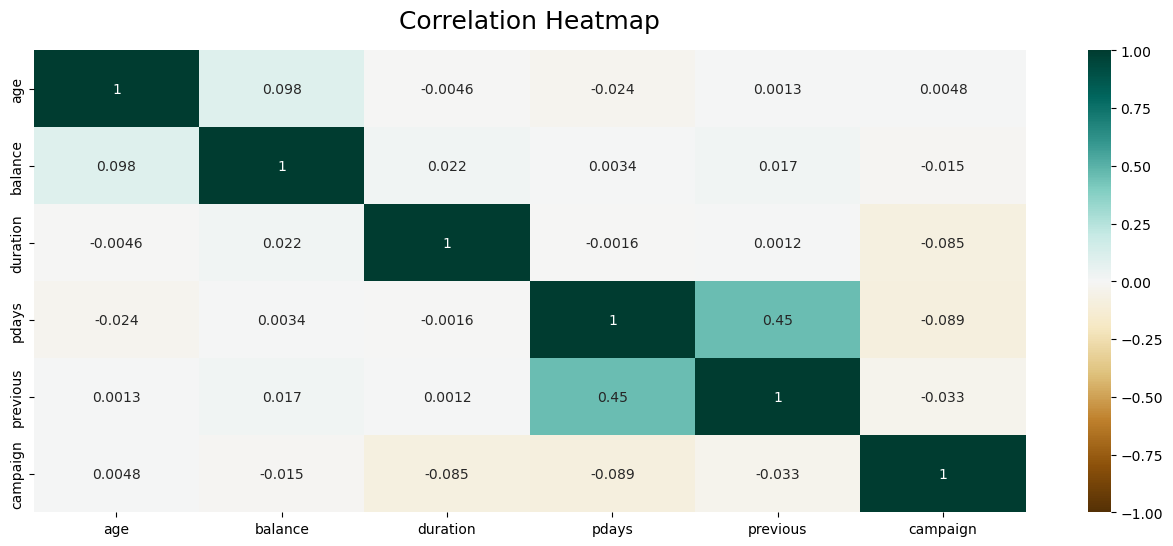

In [81]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(df_bank[numeric_columns].corr(),vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=16)
# plt.savefig('bank_heatmap.jpg',)
plt.show()

Observations:
- There is some correlation between our variable but none of those can be considered very high

In [82]:
def creating_box_hist(column, df):
    # creating a figure composed of two matplotlib.Axes objects (ax_box and ax_hist)
    f, (ax_box, ax_dis) = plt.subplots(nrows=2,sharex=True,gridspec_kw = {"height_ratios": (.20, .80)},figsize=(8, 5))  
    mean=df[column].mean()
    median=df[column].median()
    mode=df[column].mode().tolist()[0]

    f.suptitle("Data distribution of  "+ column  , fontsize=10, fontweight='bold')
    # assigning a graph to each ax

    sns.boxplot(df[column], ax=ax_box,orient = 'h',showmeans = True)

    sns.despine(top=True,right=True,left=True)
    sns.histplot(df[column],kde=False,ax=ax_dis)
    ax_dis.axvline(mean, color='r', linestyle='--',linewidth=2)
    ax_dis.axvline(median, color='g', linestyle='-',linewidth=2)
    ax_dis.axvline(mode, color='y', linestyle='-',linewidth=2)
    plt.legend({'Mean':mean,'Median':median,'Mode':mode})


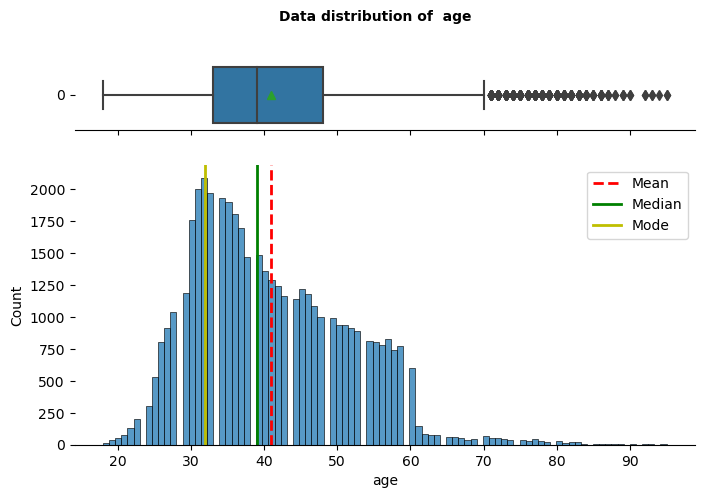

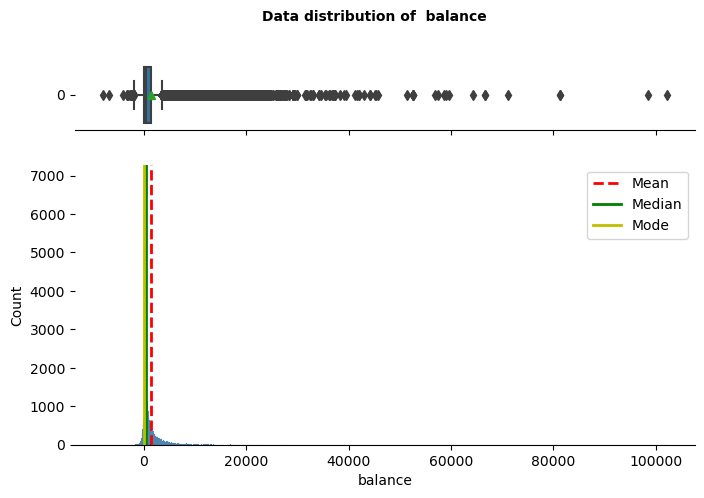

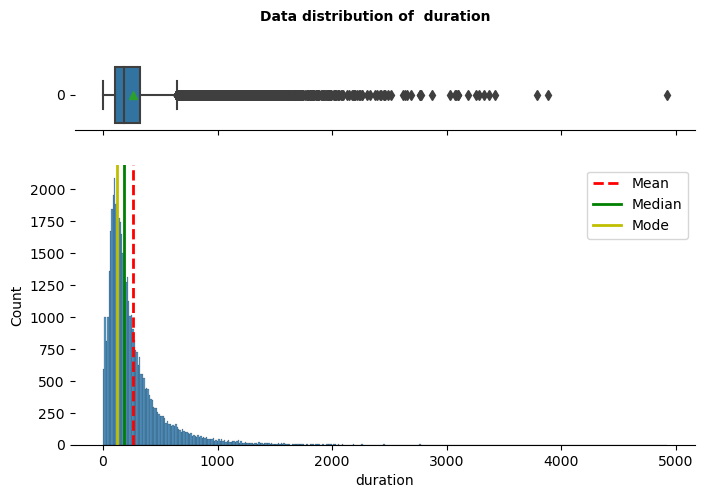

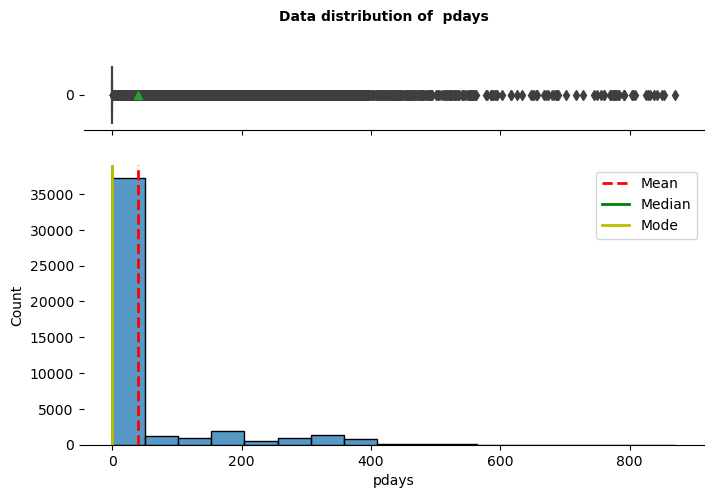

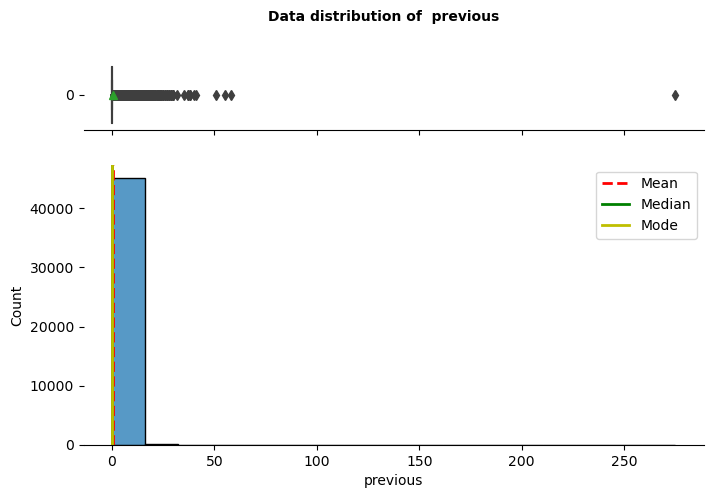

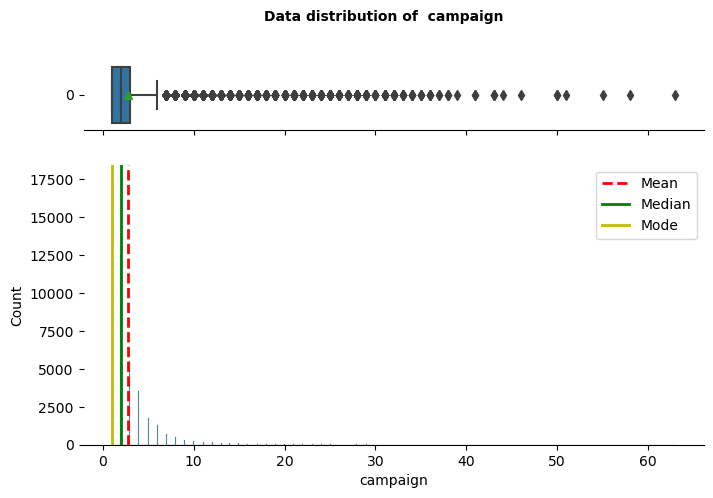

In [83]:
# Plots of numeric columns
for i in numeric_columns:
    creating_box_hist(i,df_bank)

##### Observations:
- As seen above, the majority of our data is right-skewed, eg. `Age`, `Balance` and `Duration`, `Campaign` and they have a lot of outliers.
- `Pdays` is mostly -1 which refers to the clients that have not been contacted at all and there are a lot of outliers in the data
- `Previous` is mostly 0 and there are again a lot of outliers in the data.


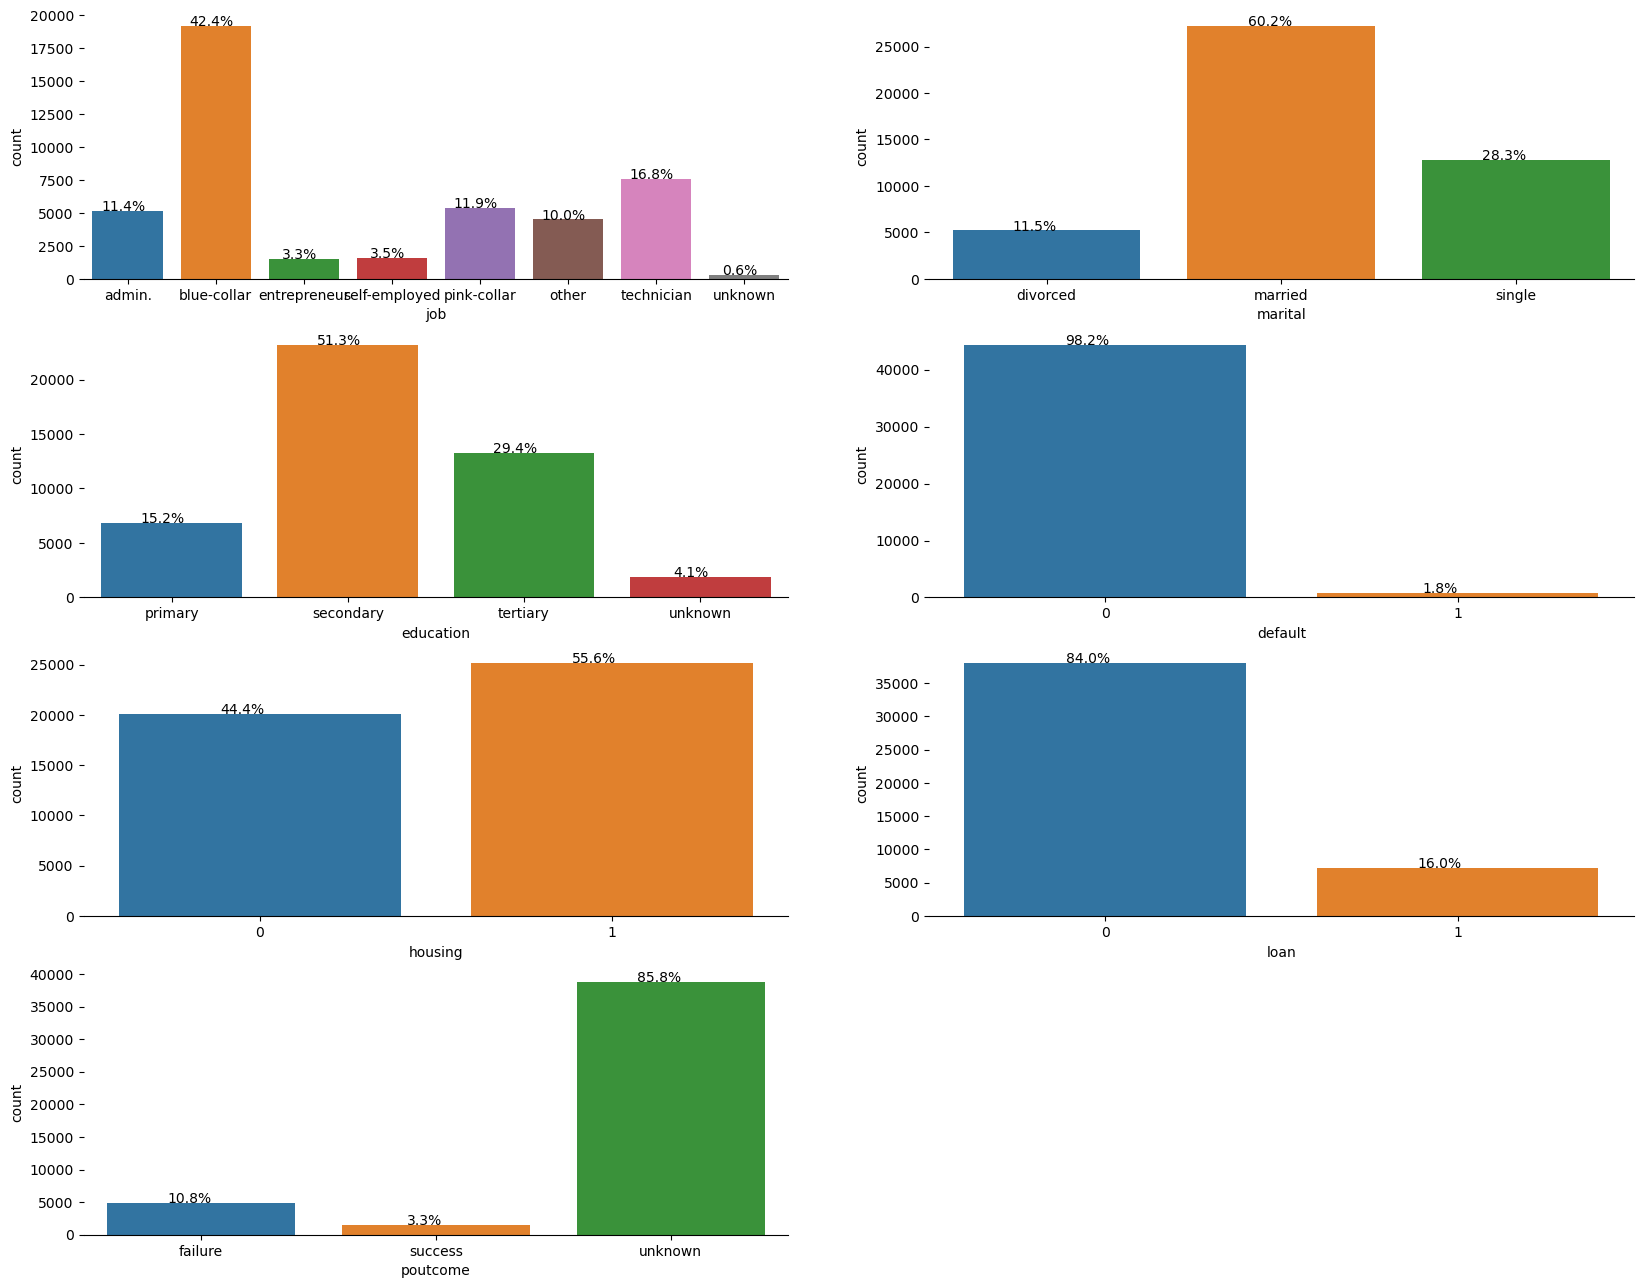

In [84]:
# Plotting the categorical variables

plt.figure(figsize=(20,20))
for i, variable in enumerate(categorical_columns):
                     plt.subplot(5,2,i+1)
                     order = df_bank[variable].value_counts(ascending=False).index 
                     ax=sns.countplot(x=df_bank[variable], data=df_bank )
                     sns.despine(top=True,right=True,left=True)
                     for p in ax.patches:
                           percentage = '{:.1f}%'.format(100 * p.get_height()/len(df_bank[variable]))
                           x = p.get_x() + p.get_width() / 2 - 0.05
                           y = p.get_y() + p.get_height()
                           plt.annotate(percentage, (x, y),ha='center')


Observations:

- `42.4%` of the clients are blue-collar employees
- `60.2%` of the clients are married
- `51.3%` of the clients have finished secondary education
- `98.2%` of the clients do not have a credit in default
- `55.6%` of the clients have housing loan
- `84%` of the clients have a personal loan 
- For `85.8%` of the clients the outcome of the previous marketing campaign is unknown

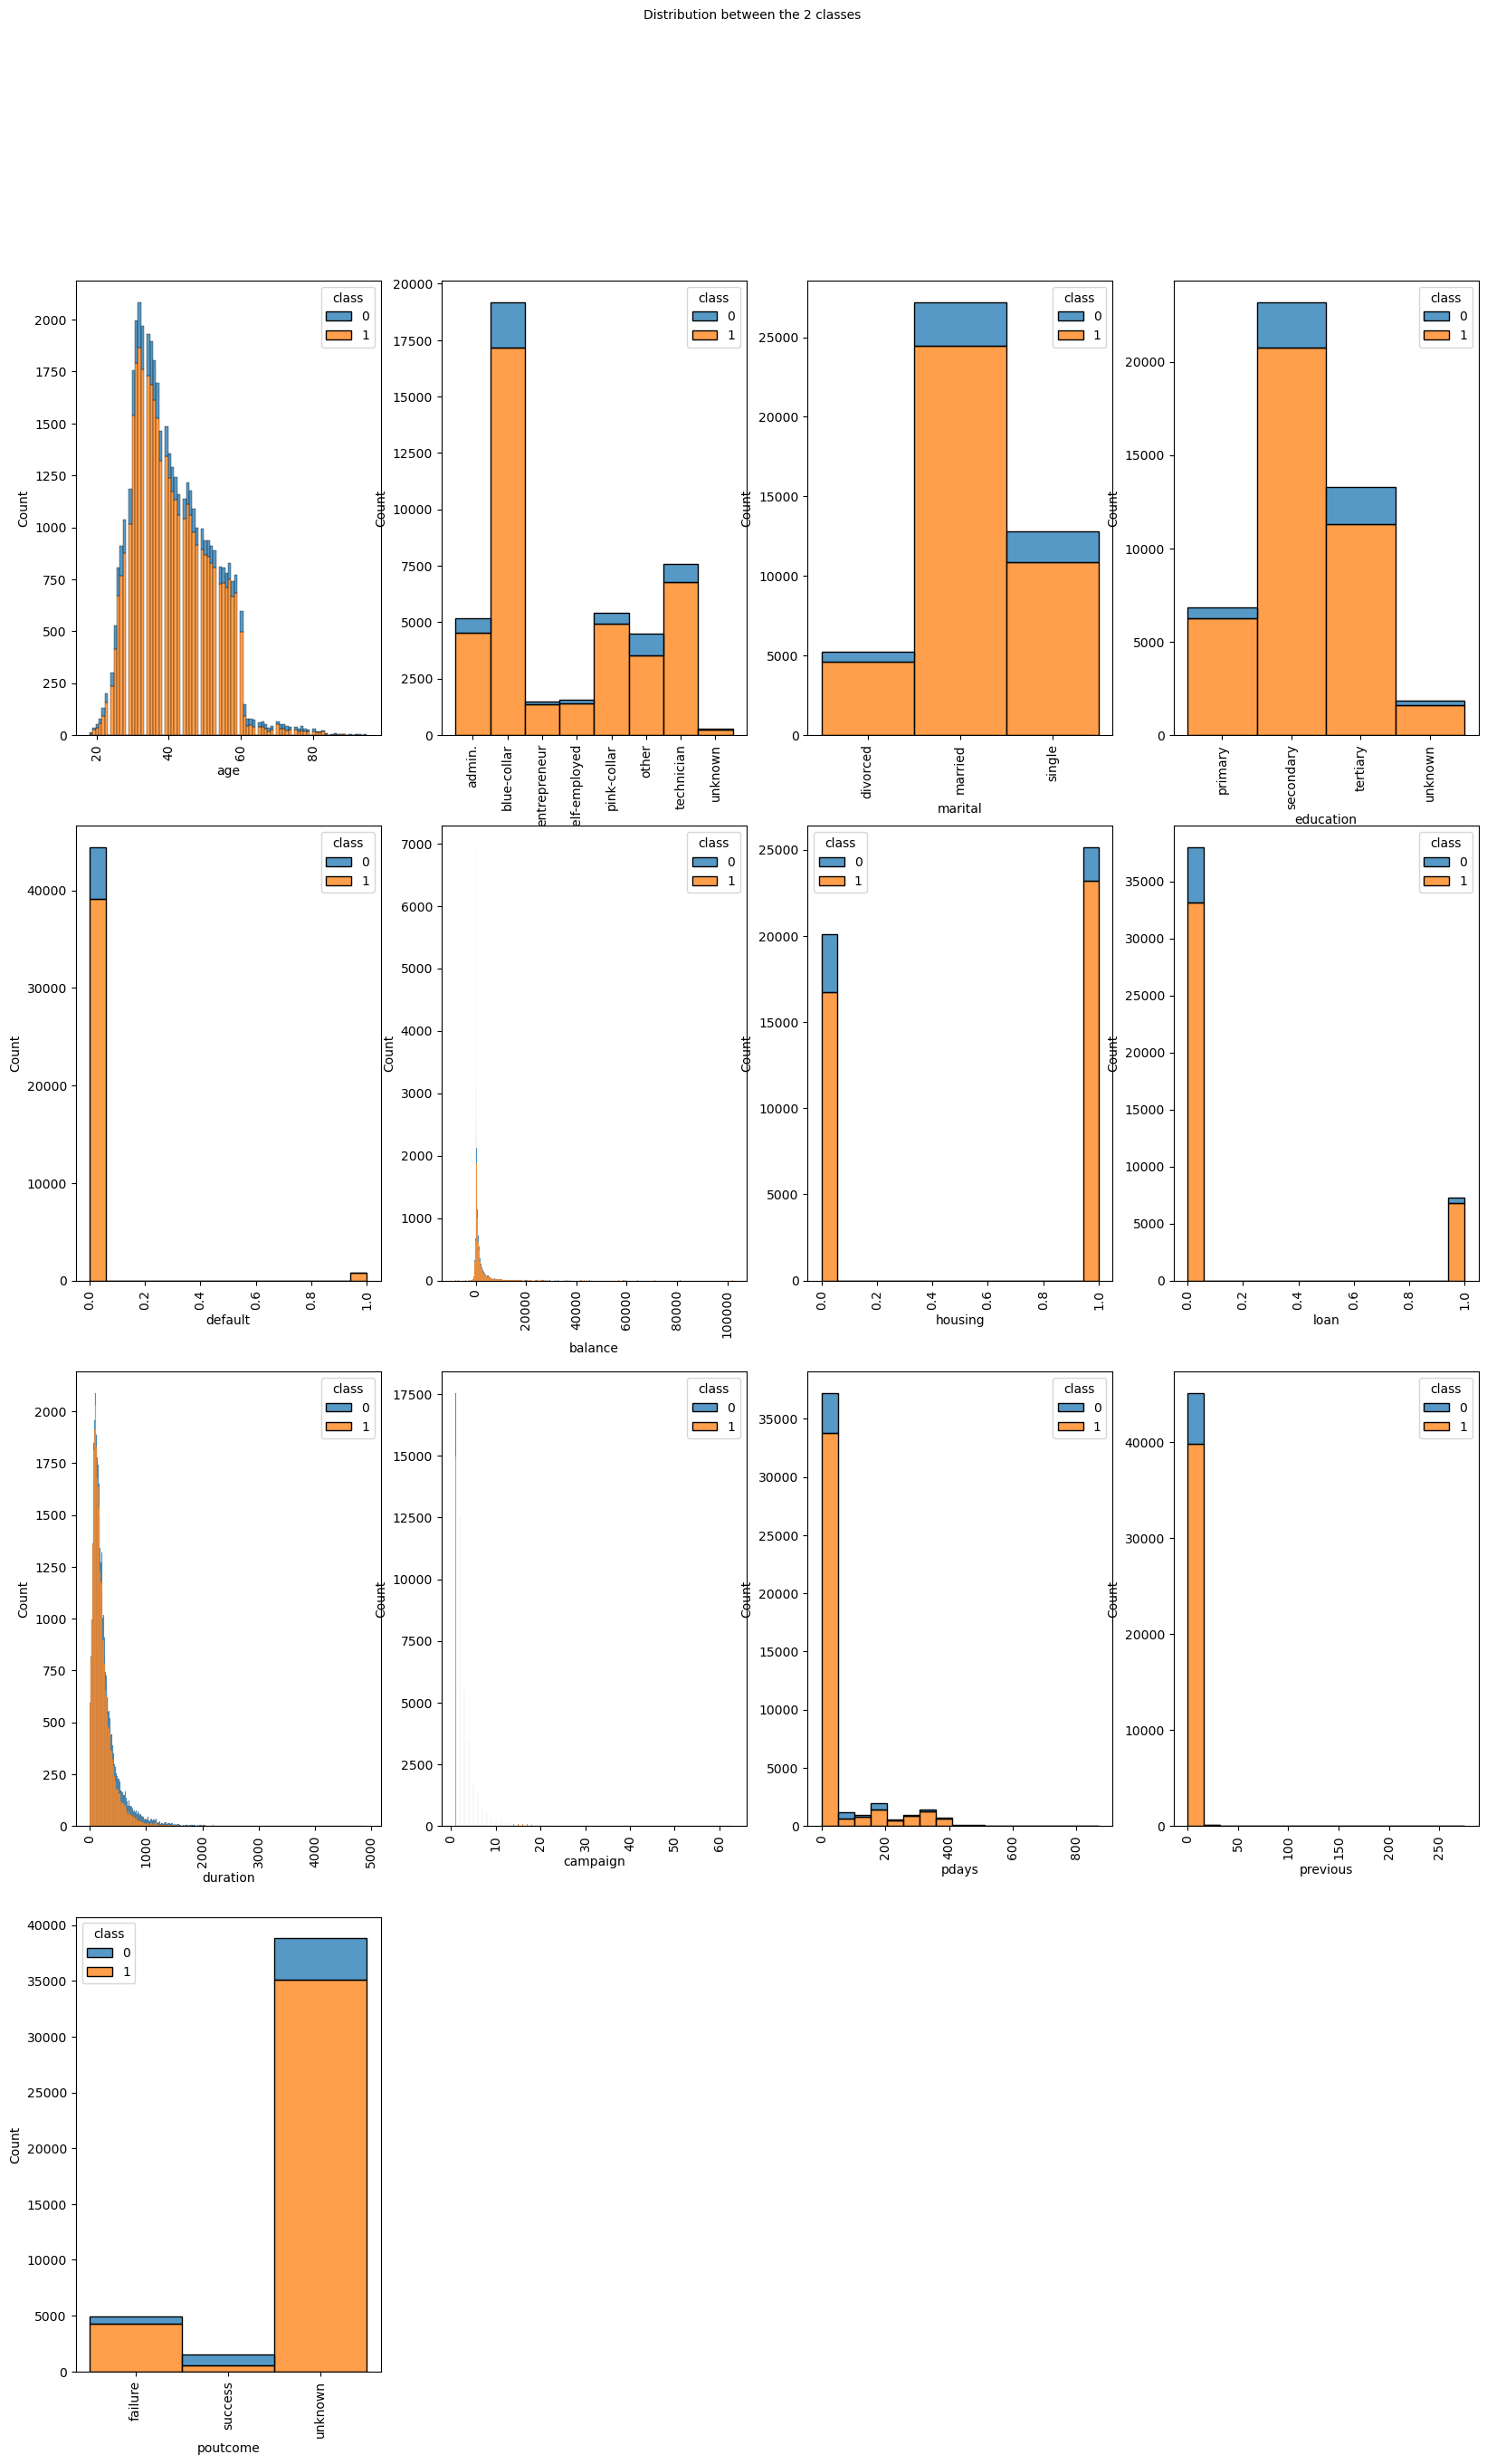

In [85]:

plt.figure(figsize=(20,30))
for i,column in enumerate([i for i in df_bank.columns.tolist() if i!='class']):
    plt.subplot(4, 4, i+1)
    sns.histplot(x=df_bank[column],hue =df_bank['class'],multiple = 'stack')
    plt.xlabel(column)
    plt.xticks(rotation=90)
plt.suptitle("Distribution between the 2 classes ", fontsize=10)
plt.show()

##### Observations:
- It looks like people between age of 30 to 40 are more likely to agree to a subscription loan.
- Number of clients employeed as a blue-collar employee that have agreed to a subscription is the highest.
- Number of clients that have finished secondary education that have agreed to a subscription is the highest.
- The majority of clients who have a credit in default or have a personal loan do not agree to a subscription
- Number of people who have not agreed to a subscription is high whether they have a housing loan or not
- Number of people about who the previous campaign result is unknow and has subscripted is high as oposed to those that had an outcome like failure.

#### Converting categorical variables to dummy variables

In [86]:
df_bank_dummies = pd.get_dummies(df_bank, columns=['job','marital','education','poutcome'],
 prefix = ['job','marital','education','poutcome'])

In [87]:
df_bank_dummies.dtypes

age                      uint8
default                  int64
balance                float64
housing                  int64
loan                     int64
duration               float64
campaign                 uint8
pdays                  float64
previous               float64
class                    int64
job_admin.               uint8
job_blue-collar          uint8
job_entrepreneur         uint8
job_self-employed        uint8
job_pink-collar          uint8
job_other                uint8
job_technician           uint8
job_unknown              uint8
marital_divorced         uint8
marital_married          uint8
marital_single           uint8
education_primary        uint8
education_secondary      uint8
education_tertiary       uint8
education_unknown        uint8
poutcome_failure         uint8
poutcome_success         uint8
poutcome_unknown         uint8
dtype: object

#### Train and Test split

In [88]:
X = df_bank_dummies.drop(['class'], axis=1)
Y = df_bank_dummies['class']

#Splitting data in train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.20, random_state = 1234,stratify=Y)

#### Decision Trees

In [89]:
#Counting the number of samples for each class
bank = df_bank.to_numpy()
bank_num_class_1 = sum(bank[:, -1] == 1)
bank_num_class_2 = sum(bank[:, -1] == 0)
print("Number of samples that belong to class 1: ", str(bank_num_class_1),bank_num_class_1/len(df_bank), '%')
print("Number of samples that belong to class 0: ", str(bank_num_class_2),bank_num_class_2/len(df_bank), '%')


Number of samples that belong to class 1:  39922 0.8830151954170445 %
Number of samples that belong to class 0:  5289 0.11698480458295547 %


- As mentioned above, our dataset is highly imbalanced. 88% of the data is represented by clients who have subscribed to a term deposit and aroung 12% by clients who have not agreed to a term deposit. Since this may have a massive effect on our prediction and the decision trees will surely be biased toward the dominant class, we can make use of the `class_weight` parameter of the model. By passing such a dictionary value {1:0.35, 0:65} to the model parameter, the decision tree will surely give more weightage to class 0.

- It is very important to identify potential customers correctly. Recall is a suitable metric in this context. The higher recall, the lower the number of False Negatives.






#### Model Tree 1

In [90]:
tree_1 = tree.DecisionTreeClassifier(random_state=1)
tree_1.fit(X_train,y_train)

DecisionTreeClassifier(random_state=1)

In [91]:
def evaluate(model, X_train=X_train, X_test=X_test):
    y_train_predict = model.predict(X_train)
    y_test_predict = model.predict(X_test)

    # accuracy
    print("#"*20)
    print("Accuracy on train: {:.2f} %".format(accuracy_score(y_true = y_train, y_pred = y_train_predict)*100))
    print("Accuracy on test: {:.2f} %".format(accuracy_score(y_test, y_test_predict)*100))

    # balanced accuracy
    print("#"*20)
    print("Balanced accuracy on train: {:.2f} %".format(balanced_accuracy_score(y_train, y_train_predict)*100))
    print("Balanced accuracy on test {:.2f} %".format(balanced_accuracy_score(y_test, y_test_predict)*100))
    print("#"*20)
    print("Recall on train: {:.2f} %".format(recall_score(y_true = y_train, y_pred = y_train_predict,average = 'macro')*100))
    print("Recall on test: {:.2f} %".format(recall_score(y_true = y_test, y_pred = y_test_predict,average = 'macro')*100))
    print("#"*20)
    print("Precision on train: {:.2f} %".format(precision_score(y_true = y_train, y_pred = y_train_predict,average = 'macro')*100))
    print("Precision on test: {:.2f} %".format(precision_score(y_true = y_test, y_pred = y_test_predict,average = 'macro')*100))

    # plot confusion matrices
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    c_1 = confusion_matrix(y_true=y_train, y_pred=y_train_predict)
    cmd_1 = ConfusionMatrixDisplay(c_1, display_labels=['subscribed_no','subscribed_yes'])
    cmd_1.plot(ax=ax[0], cmap=plt.cm.Blues)
    ax[0].set_title("Confusion matrix: train data")

    c_2 = confusion_matrix(y_true=y_test, y_pred=y_test_predict)
    cmd_2 = ConfusionMatrixDisplay(c_2, display_labels=['subscribed_no','subscribed_yes'])
    cmd_2.plot(ax=ax[1], cmap=plt.cm.Blues)
    ax[1].set_title("Confusion matrix: test data")
      
    plt.show()

####################
Accuracy on train: 100.00 %
Accuracy on test: 85.18 %
####################
Balanced accuracy on train: 100.00 %
Balanced accuracy on test 65.45 %
####################
Recall on train: 100.00 %
Recall on test: 65.45 %
####################
Precision on train: 100.00 %
Precision on test: 64.69 %


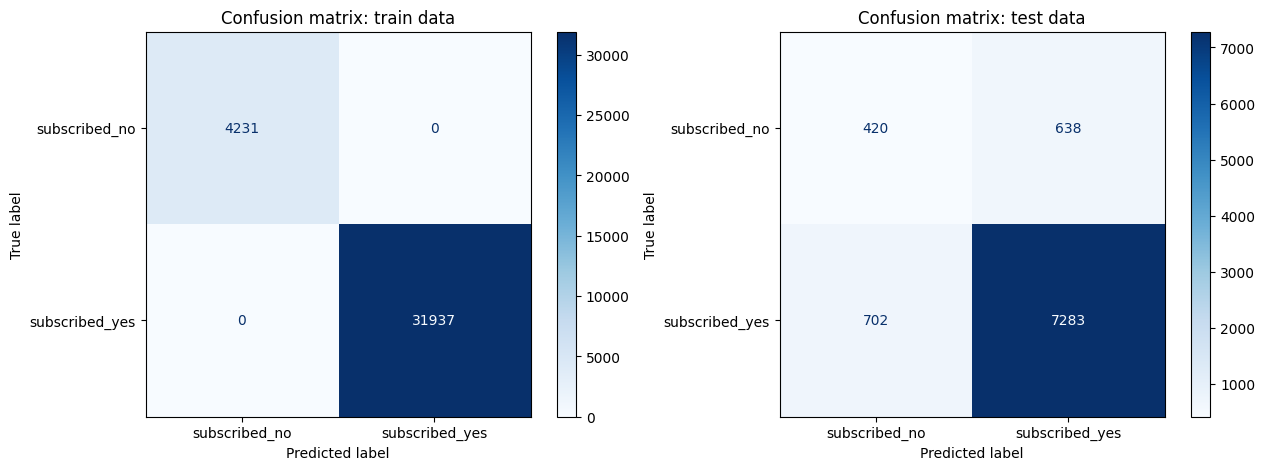

In [64]:
evaluate(tree_1)

- As seen above the recall and accuracy is very high on the train set, which suggests that the model is overfitted.

In [65]:
#features of the model
features = list(X_train)

Function for plotting the tree

In [66]:
def plottree(model):
    plt.figure(figsize=(20,30))
    plot = tree.plot_tree(model,feature_names=features,filled=True,fontsize=9,node_ids=True,class_names=True)
    for o in plot:
        arrow = o.arrow_patch
        if arrow is not None:
            arrow.set_edgecolor('black')
            arrow.set_linewidth(1)
    plt.show()

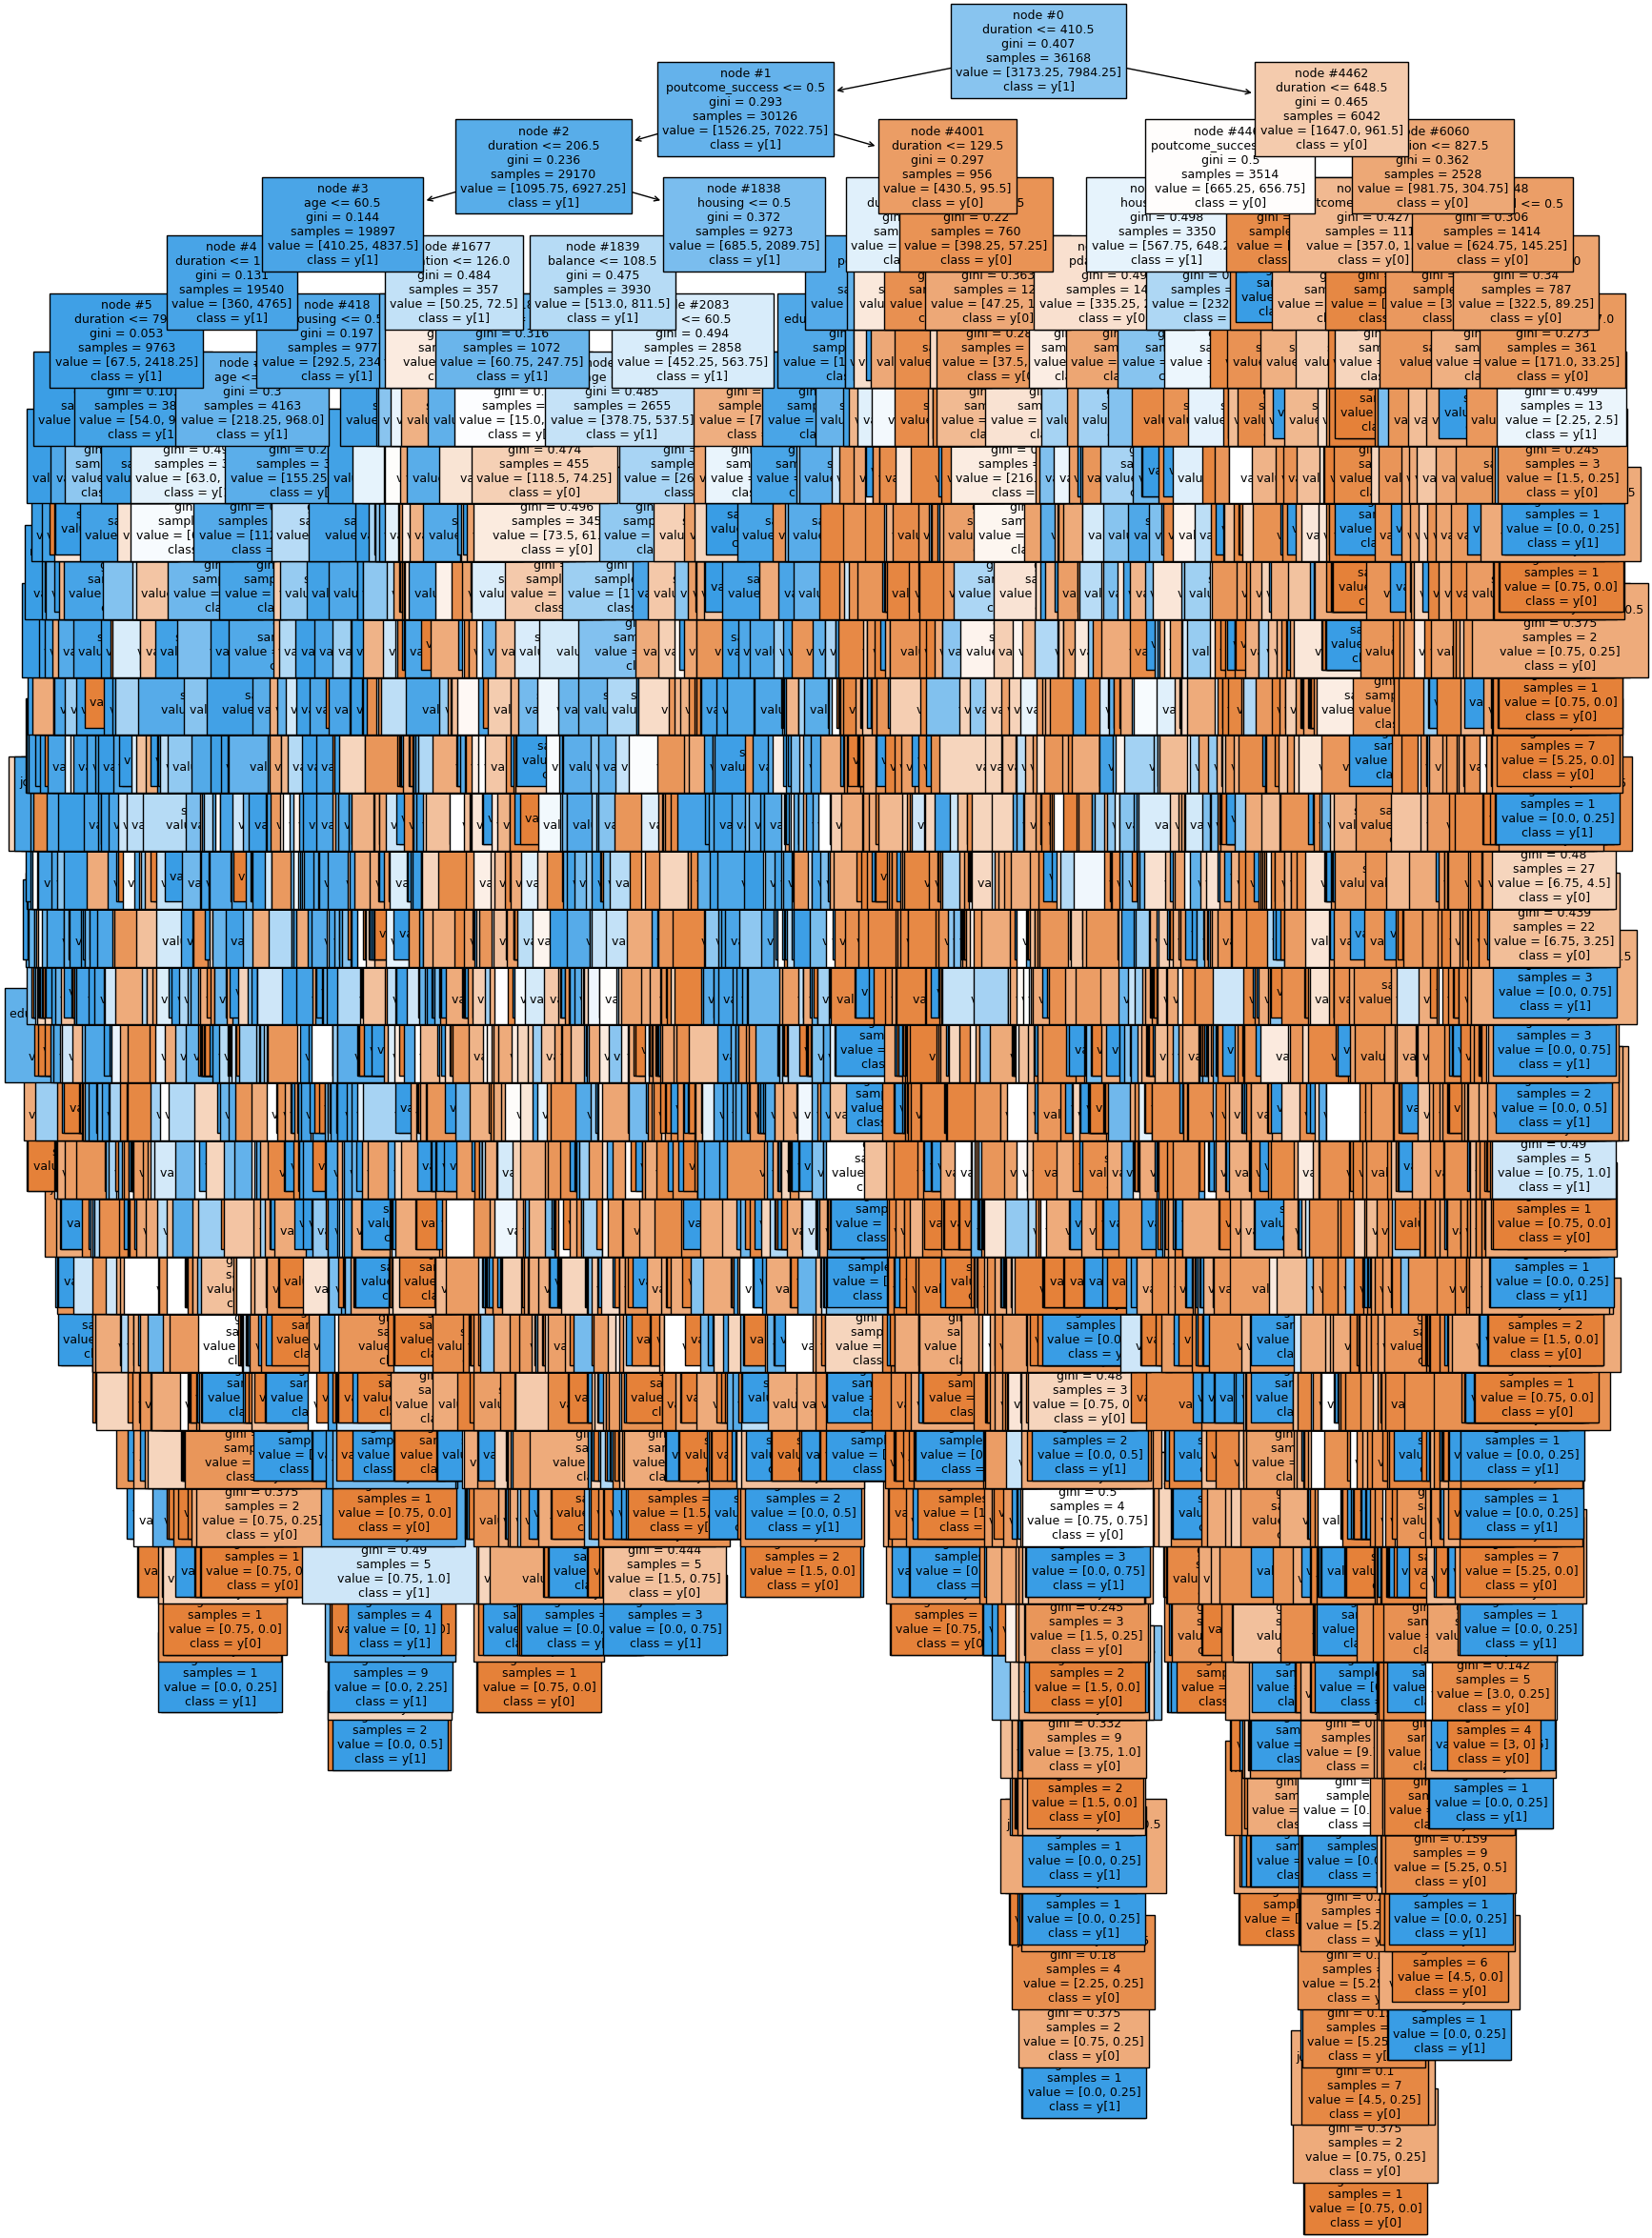

In [ ]:
plottree(tree_1)

In [87]:
def plot_features(model):
    feat_dict= {}
    for col, val in sorted(zip(features, model.feature_importances_),key=lambda x:x[1],reverse=True):
        feat_dict[col]=val
    feat_df = pd.DataFrame({'Feature':feat_dict.keys(),'Importance':feat_dict.values()})
    values = feat_df.Importance    
    idx = feat_df.Feature
    plt.figure(figsize=(10,8))
    clrs = ['navy']
    sns.barplot(y=idx,x=values,palette=clrs).set(title='Important features to predict client subscription')
    plt.show()

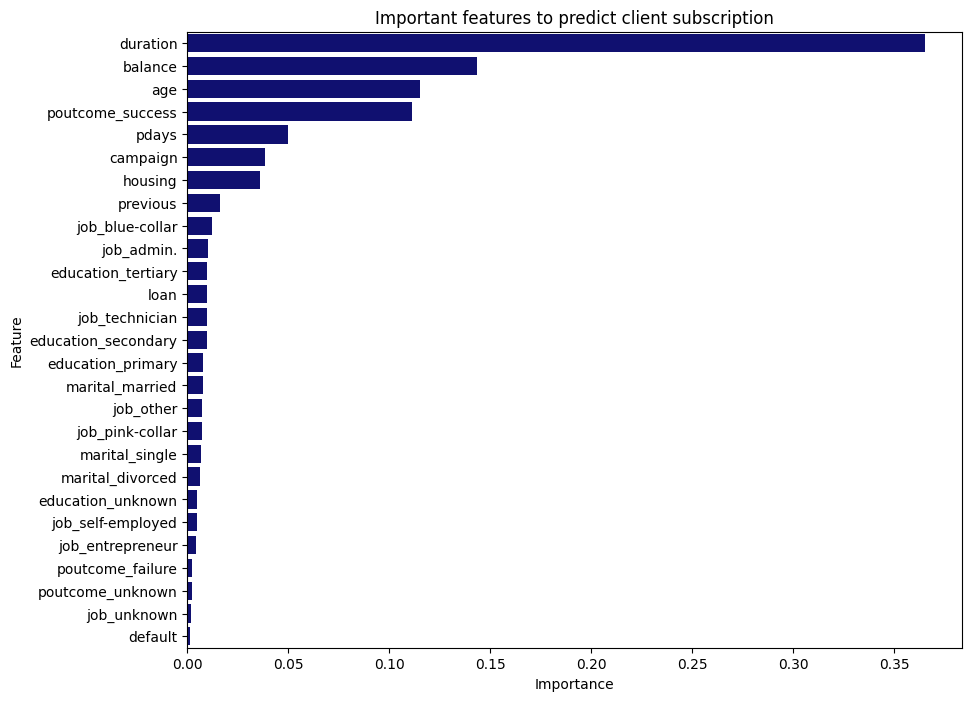

In [ ]:
plot_features(tree_1)

Observations:
- As seen above the most important feature to predict a client subscription is the `Duration` of the term deposit.
- `Balance`, `Age`, `Poutcome_sucess`, `Pdays`are other important features that offer high contribution in the prediction.
-  The least important feature is `Duration`.

##### Tree 2

In [68]:
feat_dict_1= {}
for col, val in sorted(zip(features, tree_1.feature_importances_),key=lambda x:x[1],reverse=True):
        feat_dict_1[col]=val
feat_df_1 = pd.DataFrame({'Feature':feat_dict_1.keys(),'Importance':feat_dict_1.values()})

In [69]:
X_train_new = X_train[feat_df_1[:9].Feature.to_list()]
X_test_new = X_test[feat_df_1[:9].Feature.to_list()]

In [70]:
tree_2 = tree.DecisionTreeClassifier(random_state = 3)

####################
Accuracy on train: 100.00 %
Accuracy on test: 85.45 %
####################
Balanced accuracy on train: 100.00 %
Balanced accuracy on test 67.28 %
####################
Recall on train: 100.00 %
Recall on test: 67.28 %
####################
Precision on train: 100.00 %
Precision on test: 65.74 %


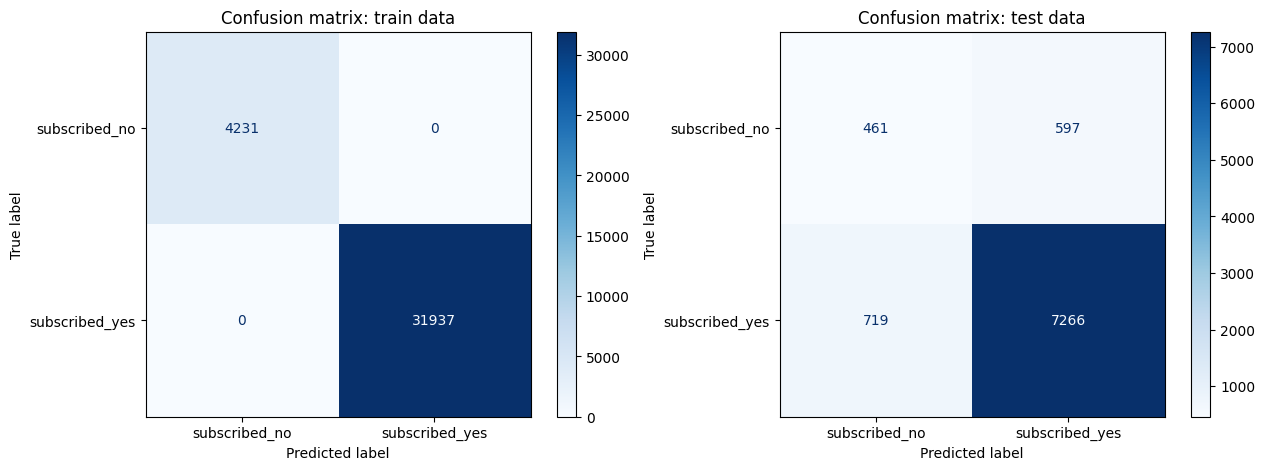

In [71]:
tree_2.fit(X_train_new,y_train)
evaluate(tree_2,X_train = X_train_new,X_test = X_test_new)

Observations:
- Feature selection does not lead to any improvement of the model performance.

##### Tree Model 3

Here we also make use of paramter class_weight since our dataset is imbalanced.

In [75]:

tree_3 = tree.DecisionTreeClassifier(class_weight={1:0.20,0:0.80},  random_state=1)
tree_3.fit(X_train,y_train)


DecisionTreeClassifier(class_weight={0: 0.8, 1: 0.2}, random_state=1)

####################
Accuracy on train: 100.00 %
Accuracy on test: 85.62 %
####################
Balanced accuracy on train: 100.00 %
Balanced accuracy on test 65.66 %
####################
Recall on train: 100.00 %
Recall on test: 65.66 %
####################
Precision on train: 100.00 %
Precision on test: 65.39 %


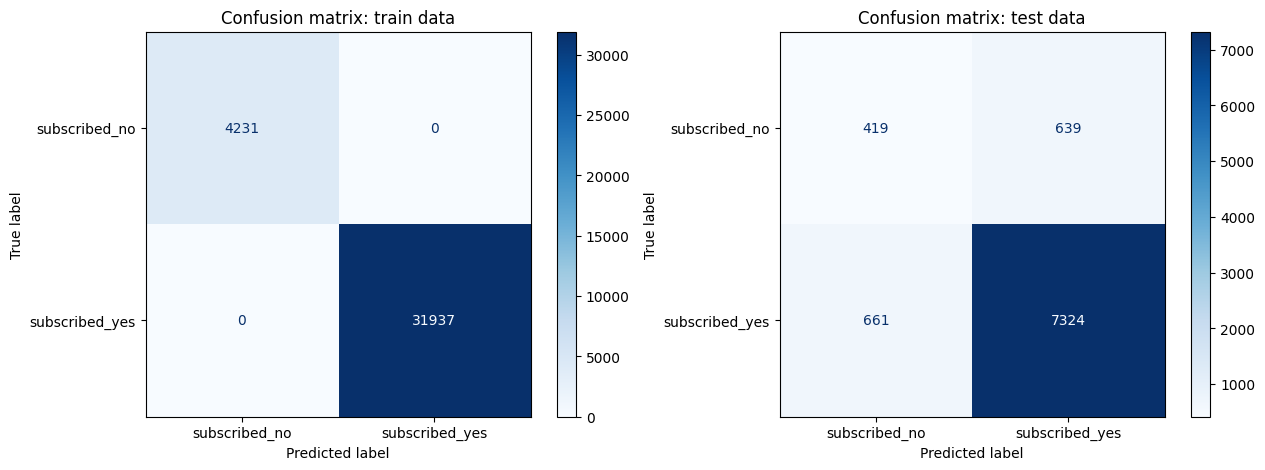

In [76]:
evaluate(tree_3)

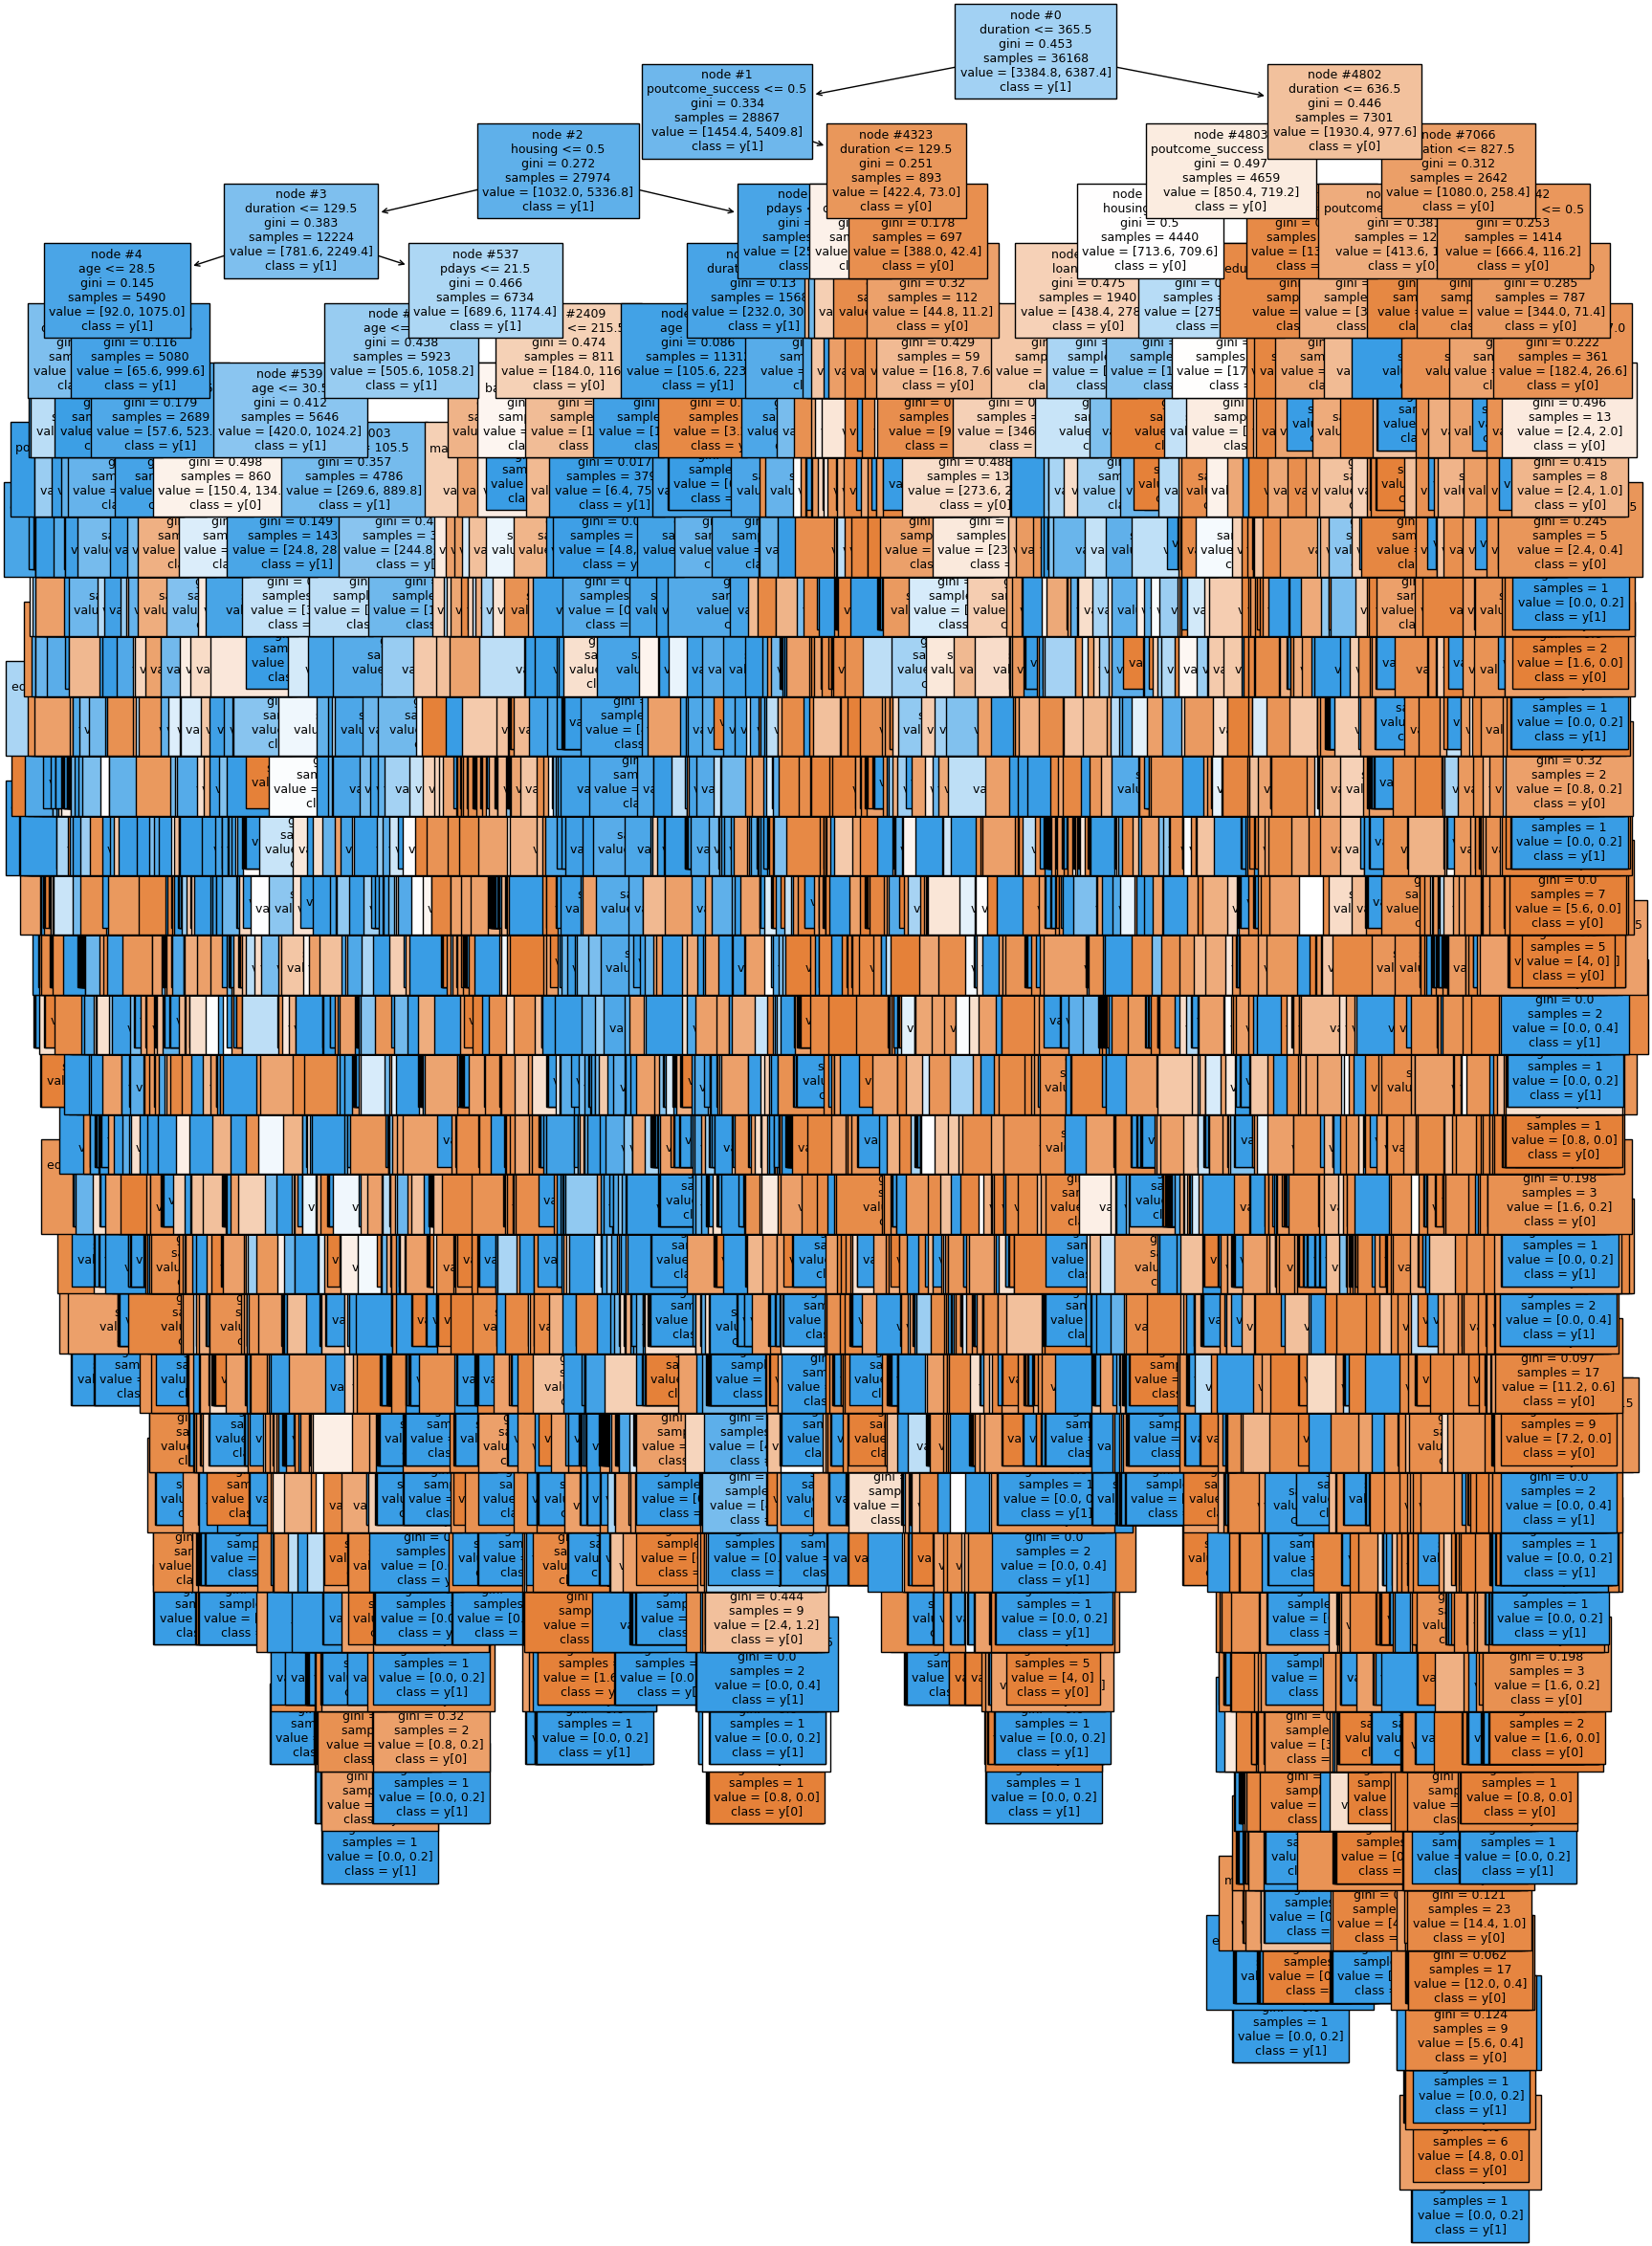

In [64]:
plottree(tree_3)

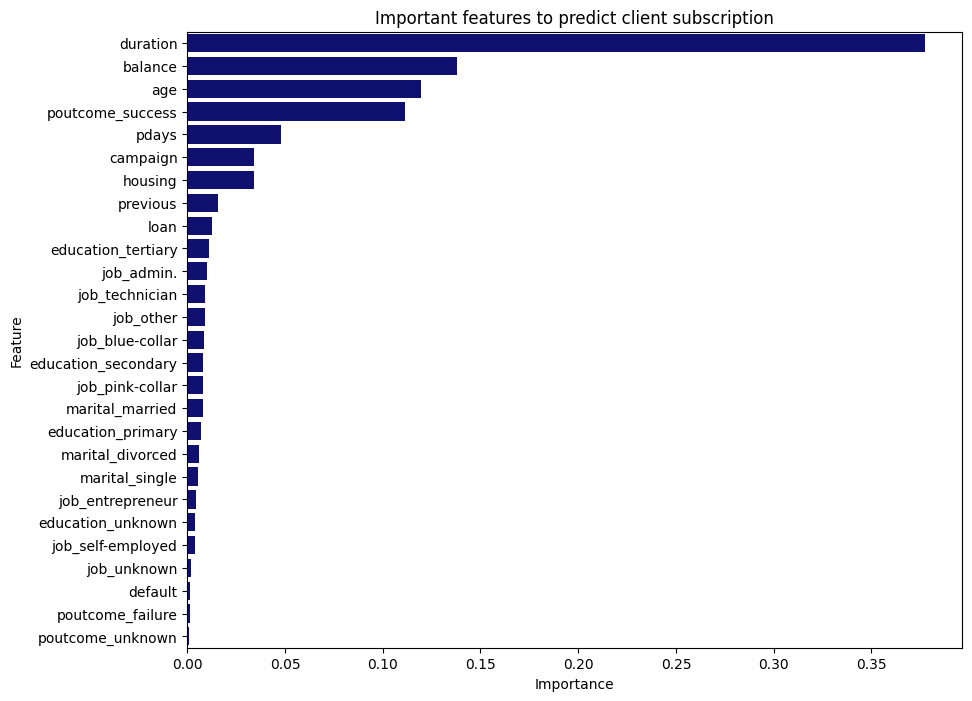

In [65]:
plot_features(tree_3)

Observations:
- The second random model does not decrease the overfit.
- Even when using the parameter `class_weight` the balanced accuracy does not improve.
- Our tree is quite huge, so it is sure in need of pruning. 

#### Grid Search for parameter tuning

In [80]:
estimator  = tree.DecisionTreeClassifier(random_state=1)

parameters = {'max_depth': np.arange(1,10), 
              'max_leaf_nodes' : [5, 10,15,20,25,30,35,40,45,50],
              'class_weight':[{1:0.25,0:0.75},{1:0.20,0:0.80},{1:0.35,0:0.65}],
              'criterion': ['gini','entropy','log_loss']}
              
scorer = make_scorer(accuracy_score)

kf = KFold(n_splits=5, shuffle=True, random_state=1)


grid = GridSearchCV(estimator = estimator,param_grid = parameters,scoring = scorer, cv = kf)
grid = grid.fit(X_train,y_train)

In [82]:
#best combination

# DecisionTreeClassifier(class_weight={0: 0.65, 1: 0.35}, max_depth=6,
#                        max_leaf_nodes=35, random_state=1)
tree_best = grid.best_estimator_
tree_best

DecisionTreeClassifier(class_weight={0: 0.65, 1: 0.35}, max_depth=6,
                       max_leaf_nodes=35, random_state=1)

Fitting the model with the best combination of paramters:

In [83]:
tree_best.fit(X_train,y_train)

DecisionTreeClassifier(class_weight={0: 0.65, 1: 0.35}, max_depth=6,
                       max_leaf_nodes=35, random_state=1)

####################
Accuracy on train: 89.87 %
Accuracy on test: 89.14 %
####################
Balanced accuracy on train: 74.18 %
Balanced accuracy on test 72.41 %
####################
Recall on train: 74.18 %
Recall on test: 72.41 %
####################
Precision on train: 75.52 %
Precision on test: 73.66 %


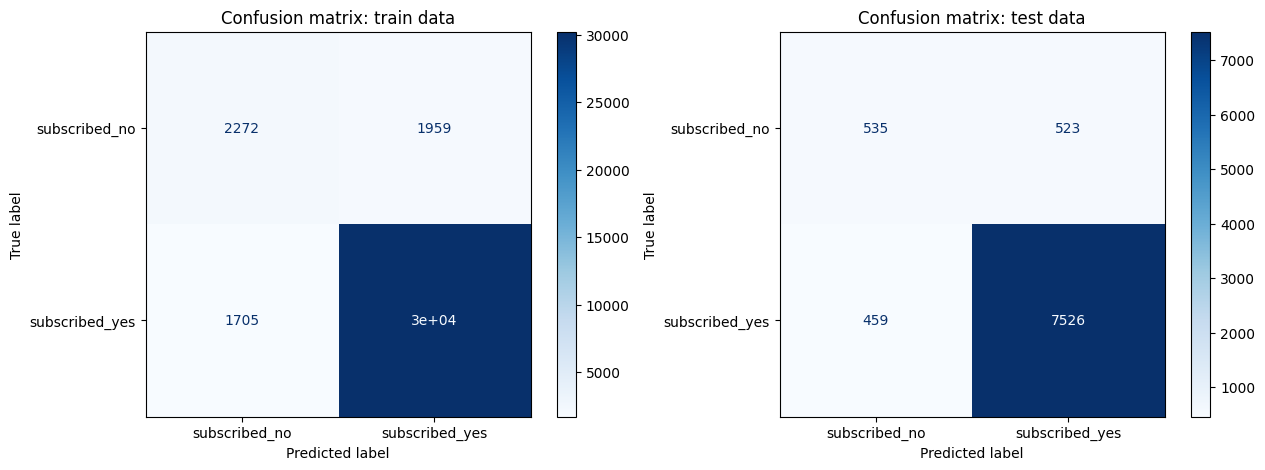

In [84]:
evaluate(tree_best)

Observations:

- As seen above, the overfit of the model is clearly reduced.
- Moreover, there is an increase in overall accuray to 89%, in balanced accuracy to 72% and recall to 94%.

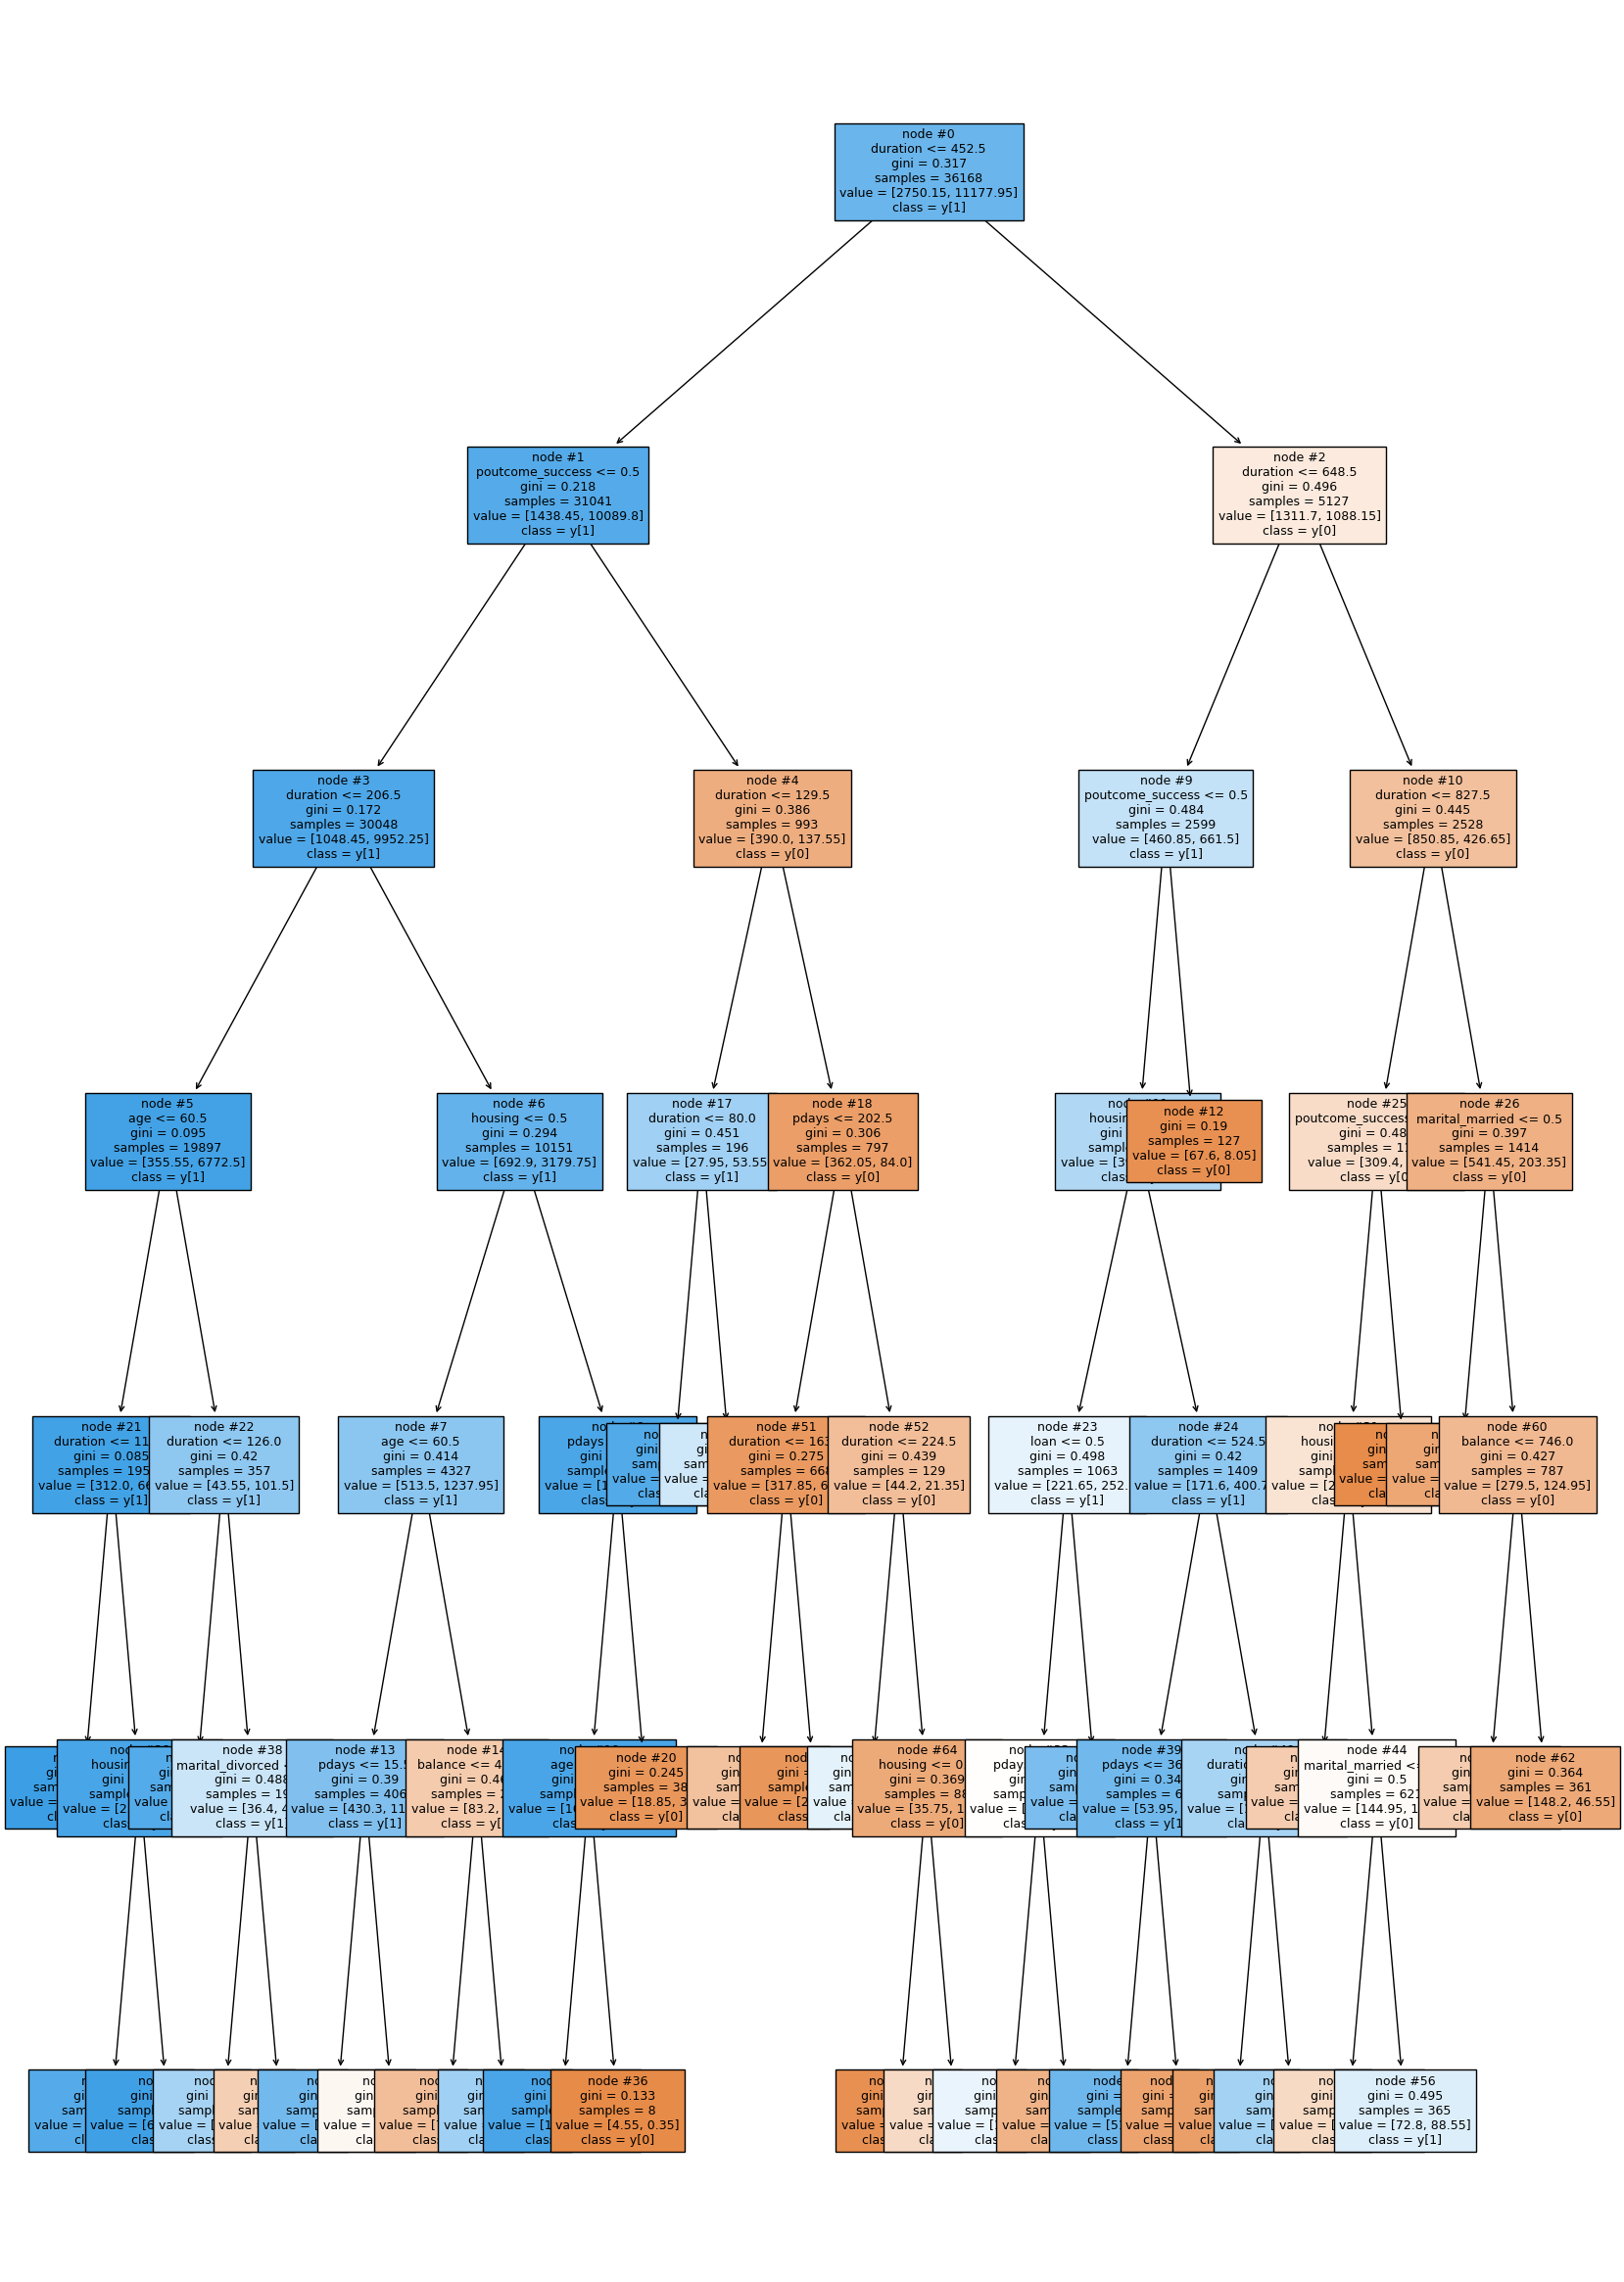

In [85]:
plottree(tree_best)

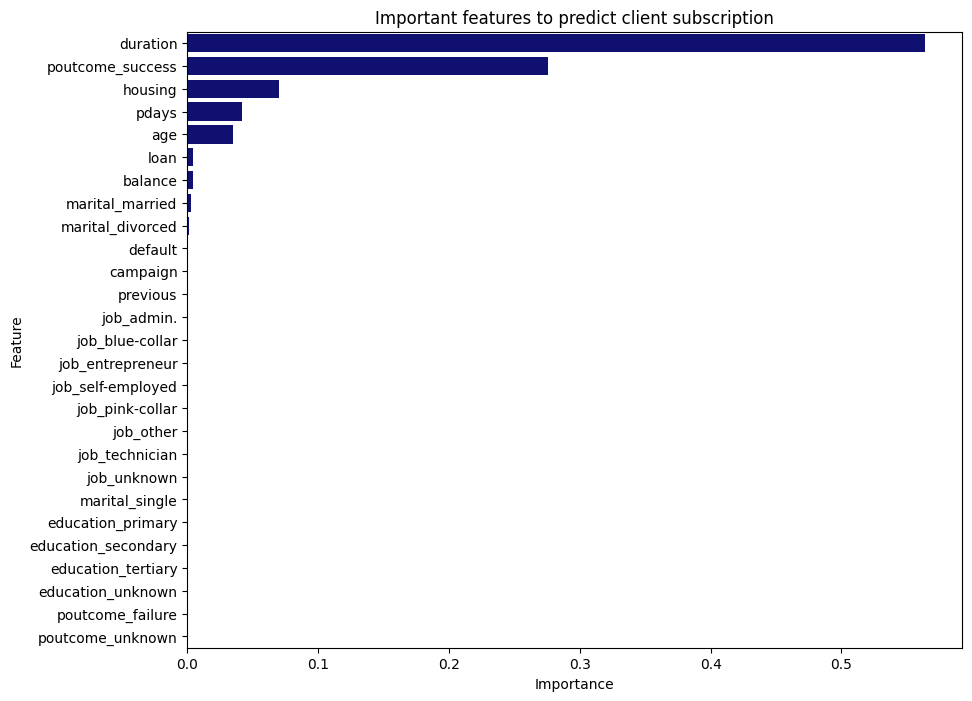

In [88]:
plot_features(tree_best)

Observations:

- According to the best model, the most important features for the prediction are `Duration` and `Poutcome_success`,`Housing`,`Pdays`, `Age` and `Education_tertiary`.

#### Cost Complexity Pruning of Tree
As last step of the Decision Tree model, we will perform post-pruning techniques.


In [119]:
# prune the tree with cost complexity pruning — Alpha
path = tree.DecisionTreeClassifier(random_state = 1).cost_complexity_pruning_path(X_train, y_train)
alphas, impurities = path.ccp_alphas, path.impurities
mean, std = [], []
for i in alphas[:100]:
 tree_ = tree.DecisionTreeClassifier(ccp_alpha=i, random_state=0)
 scores = cross_val_score(tree_, X_train, y_train, cv=5)
 mean.append(scores.mean())
 std.append(scores.std())
# keep a record of the values of alpha, mean accuracy rate, standard deviation of accuracies
eva_df = pd.DataFrame({'alpha': alphas[:100], 'mean_score': mean, 'std': std})
eva_df = eva_df.sort_values(['alpha'], ascending = True)
eva_df.head(10)

alpha  mean_score      std
0  0.000000    0.856033  0.00352
1  0.000011    0.856033  0.00352
2  0.000011    0.856033  0.00352
3  0.000012    0.856033  0.00352
4  0.000014    0.856033  0.00352
5  0.000014    0.856033  0.00352
6  0.000014    0.856033  0.00352
7  0.000014    0.856033  0.00352
8  0.000014    0.856033  0.00352
9  0.000014    0.856033  0.00352

In [122]:
eva_df

alpha  mean_score       std
0   0.000000    0.856033  0.003520
1   0.000011    0.856033  0.003520
2   0.000011    0.856033  0.003520
3   0.000012    0.856033  0.003520
4   0.000014    0.856033  0.003520
..       ...         ...       ...
95  0.000021    0.856890  0.003655
96  0.000021    0.856890  0.003655
97  0.000021    0.856890  0.003655
98  0.000021    0.856918  0.003629
99  0.000021    0.856918  0.003629

[100 rows x 3 columns]

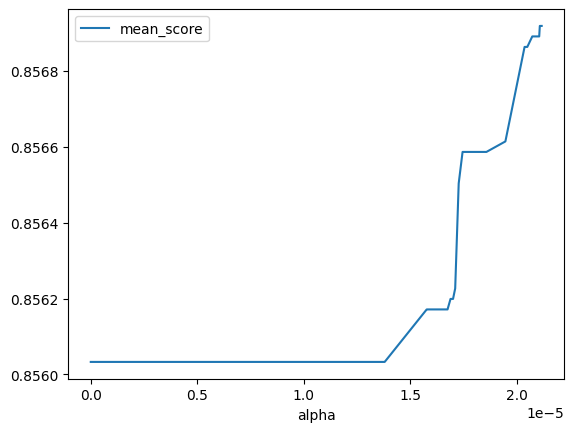

In [120]:
eva_df.plot(x = 'alpha',y = 'mean_score')
plt.show()

In [123]:
tree_pruned = tree.DecisionTreeClassifier(ccp_alpha = 0.000021,random_state = 1)
tree_pruned.fit(X_train,y_train)

DecisionTreeClassifier(ccp_alpha=2.1e-05, random_state=1)

####################
Accuracy on train: 99.65 %
Accuracy on test: 85.54 %
####################
Balanced accuracy on train: 98.56 %
Balanced accuracy on test 65.49 %
####################
Recall on train: 98.56 %
Recall on test: 65.49 %
####################
Precision on train: 99.73 %
Precision on test: 65.19 %


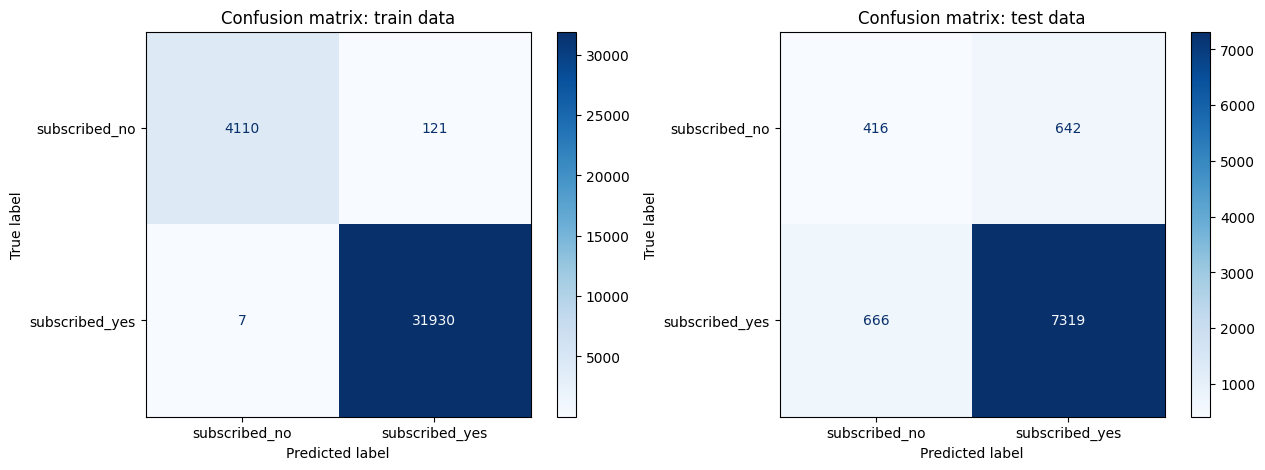

In [124]:
evaluate(tree_pruned)

Observations:
- As seen above a post pruning of the tree does not decrease overfit much and the test accuracy amounts to 85.54%.

### k-NN Classifier

In [27]:
X.head()

age  default  balance  housing  loan  duration  campaign  pdays  previous  \
0   58        0   2143.0        1     0     261.0         1   -1.0       0.0   
1   44        0     29.0        1     0     151.0         1   -1.0       0.0   
2   33        0      2.0        1     1      76.0         1   -1.0       0.0   
3   47        0   1506.0        1     0      92.0         1   -1.0       0.0   
4   33        0      1.0        0     0     198.0         1   -1.0       0.0   

   job_admin.  ...  marital_divorced  marital_married  marital_single  \
0           0  ...                 0                1               0   
1           0  ...                 0                0               1   
2           0  ...                 0                1               0   
3           0  ...                 0                1               0   
4           0  ...                 0                0               1   

   education_primary  education_secondary  education_tertiary  \
0                  0                    0                   1   
1                  0                    1                   0   
2                  0                    1                   0   
3                  0                    0                   0   
4                  0                    0                   0   

   education_unknown  poutcome_failure  poutcome_success  poutcome_unknown  
0                  0                 0                 0                 1  
1                  0                 0                 0                 1  
2                  0                 0                 0                 1  
3                  1                 0                 0                 1  
4                  1                 0                 0                 1  

[5 rows x 27 columns]

In [28]:
Y.head()

0    1
1    1
2    1
3    1
4    1
Name: class, dtype: int64

Since k-NN classifier relies on distance, scaling (Z-score standardisation) is a must! Let's ensure that all variables have mean of 0 and standard deviation of 1.

In [29]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_standardized = scaler.fit_transform(X_train)
X_test_standardized = scaler.transform(X_test)



print('TRAINING')
print('Original data:')
print('Mean:')
print(X_train.mean(axis=0))
print('Std:')
print(X_train.std(axis=0))
print()
print('Standardized data:')
print('Mean:')
print(X_train_standardized.mean(axis=0))
print('Std:')
print(X_train_standardized.std(axis=0))

print('#'*100)


print('TESTING')
print('Original data:')
print('Mean:')
print(X_test.mean(axis=0))
print('Std:')
print(X_test.std(axis=0))
print()
print('Standardized data:')
print('Mean:')
print(X_test_standardized.mean(axis=0))
print('Std:')
print(X_test_standardized.std(axis=0))


X_train = X_train_standardized
X_test = X_test_standardized

TRAINING
Original data:
Mean:
age                      40.931984
default                   0.018248
balance                1348.653838
housing                   0.555270
loan                      0.159036
duration                258.570615
campaign                  2.764405
pdays                    39.952334
previous                  0.579601
job_admin.                0.113277
job_blue-collar           0.423551
job_entrepreneur          0.032957
job_self-employed         0.035418
job_pink-collar           0.120051
job_other                 0.099812
job_technician            0.168685
job_unknown               0.006249
marital_divorced          0.116567
marital_married           0.599646
marital_single            0.283787
education_primary         0.151681
education_secondary       0.512470
education_tertiary        0.294487
education_unknown         0.041363
poutcome_failure          0.107305
poutcome_success          0.034008
poutcome_unknown          0.858687
dtype: float64
Std:
age  

In [30]:
def knn_evaluate(model):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # accuracy
    print("#"*50)
    print("Accuracy on train: ", accuracy_score(y_true=y_train, y_pred=y_train_pred))
    print("Accuracy on test: ", accuracy_score(y_true=y_test, y_pred=y_test_pred))
    # recall
    print("#"*50)
    print("Recall on train: ", recall_score(y_true=y_train, y_pred=y_train_pred))
    print("Recall on test: ", recall_score(y_true=y_test, y_pred=y_test_pred))
    # precision
    print("#"*50)
    print("Precision on train: ", precision_score(y_true=y_train, y_pred=y_train_pred))
    print("Precision on test: ", precision_score(y_true=y_test, y_pred=y_test_pred))
    # balanced accuracy (imbalanced classes)
    print("#"*50)
    print("Balanced accuracy on train: ", balanced_accuracy_score(y_true=y_train, y_pred=y_train_pred))
    print("Balanced accuracy on test: ", balanced_accuracy_score(y_true=y_test, y_pred=y_test_pred))

    # plot confusion matrices
    print("#"*50)
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    c_1 = confusion_matrix(y_true=y_train, y_pred=y_train_pred)
    cmd_1 = ConfusionMatrixDisplay(c_1, display_labels=['subscribed_no', 'subscribed_yes'])
    cmd_1.plot(ax=ax[0], cmap=plt.cm.Blues)
    ax[0].set_title("Confusion matrix: train data")

    c_2 = confusion_matrix(y_true=y_test, y_pred=y_test_pred)
    cmd_2 = ConfusionMatrixDisplay(c_2, display_labels=['subscribed_no', 'subscribed_yes'])
    cmd_2.plot(ax=ax[1], cmap=plt.cm.Blues)
    ax[1].set_title("Confusion matrix: test data")

    k = model.n_neighbors
    plt.tight_layout()
    plt.suptitle("k-NN classifier, k = " + str(k), fontsize=15, ha='center')
    plt.subplots_adjust(top=0.85)

    plt.show()

##################################################
Accuracy on train:  0.9284173855341739
Accuracy on test:  0.8821187658962734
##################################################
Recall on train:  0.9802110404859568
Recall on test:  0.955917345021916
##################################################
Precision on train:  0.9411640911550718
Precision on test:  0.9144602851323829
##################################################
Balanced accuracy on train:  0.7588363167449874
Balanced accuracy on test:  0.6405295609797671
##################################################


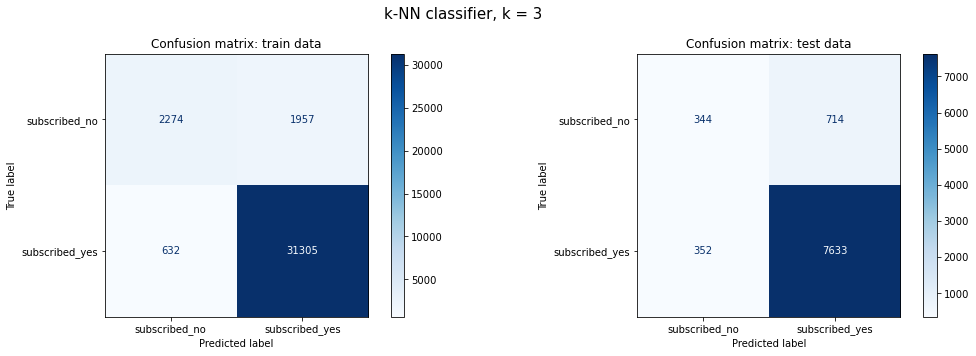

In [31]:
# 1st model
from sklearn.neighbors import KNeighborsClassifier
k = 3
knn_1 = KNeighborsClassifier(n_neighbors=k)
knn_1.fit(X_train, y_train)

knn_evaluate(knn_1)

When dealing with imbalanced data, the accuracy metric is not an objective measure of the classifier's performance. It is important to consider metrics such as balanced accuracy, which takes into account the imbalance in the data. In this case, the presented model has a low balanced accuracy, indicating that it's not good. 
Improving k-NN classifier by implementing weighted approach...

### Weighted approach

##################################################
Accuracy on train:  1.0
Accuracy on test:  0.8805706070994139
##################################################
Recall on train:  1.0
Recall on test:  0.9525360050093926
##################################################
Precision on train:  1.0
Precision on test:  0.9156133381485494
##################################################
Balanced accuracy on train:  1.0
Balanced accuracy on test:  0.6449825582702917
##################################################


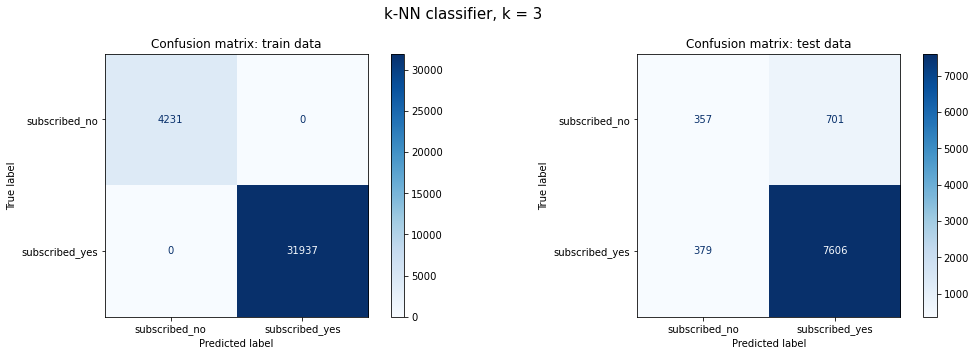

In [32]:
# 1st model
k = 3
knn_1 = KNeighborsClassifier(n_neighbors=k, weights='distance')
knn_1.fit(X_train, y_train)

knn_evaluate(knn_1)



##################################################
Accuracy on train:  1.0
Accuracy on test:  0.8883114010837112
##################################################
Recall on train:  1.0
Recall on test:  0.9629304946775203
##################################################
Precision on train:  1.0
Precision on test:  0.9150303463048911
##################################################
Balanced accuracy on train:  1.0
Balanced accuracy on test:  0.6440361358075692
##################################################


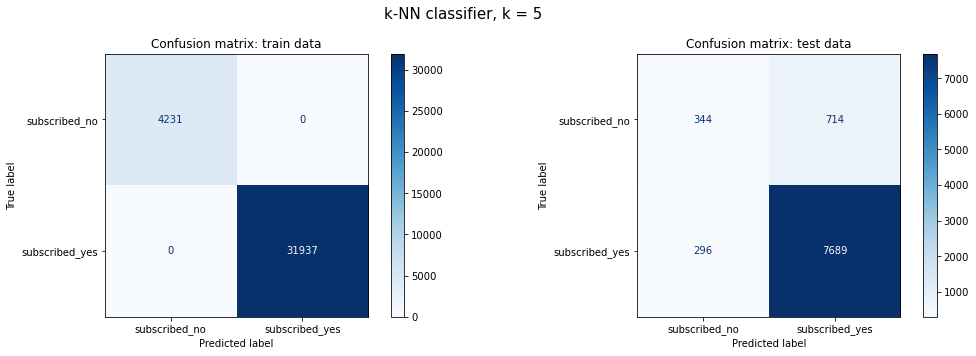

In [33]:
# 2nd model
k = 5
knn_2 = KNeighborsClassifier(n_neighbors=k, weights='distance')
knn_2.fit(X_train, y_train)

knn_evaluate(knn_2)

Generalizing really, really bad!!! Consider outliers maybe!

### Undersampling the majority class

Trying: Undersampling the majority class involves reducing the number of samples in the majority class to balance the class distribution

In [34]:
n_minority = len(y_train[y_train == 0])
n_majority = len(y_train[y_train == 1])
print(n_minority, n_majority)

4231 31937


In [36]:
from imblearn.under_sampling import RandomUnderSampler

ratio = 1.0  # ratio of majority class to minority class
seed = 1  # random seed for reproducibility

undersampler = RandomUnderSampler(sampling_strategy=ratio, random_state=seed)
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)


Problem: a lot of data is thrown away

In [37]:
n_minority = len(y_train_resampled[y_train_resampled == 0])
n_majority = len(y_train_resampled[y_train_resampled == 1])
print(n_minority, n_majority)

4231 4231


##################################################
Accuracy on train:  0.8233797832337978
Accuracy on test:  0.7584872276899259
##################################################
Recall on train:  0.7999812130131195
Recall on test:  0.7640576080150282
##################################################
Precision on train:  1.0
Precision on test:  0.9531323230745196
##################################################
Balanced accuracy on train:  0.8999906065065597
Balanced accuracy on test:  0.7402518663893667
##################################################


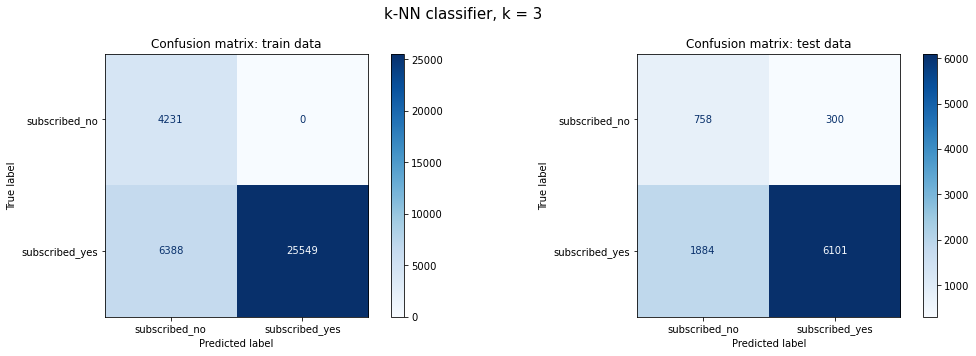

In [38]:
# 1st model
k = 3
knn_1 = KNeighborsClassifier(n_neighbors=k, weights='distance')
knn_1.fit(X_train_resampled, y_train_resampled)

knn_evaluate(knn_1)


##################################################
Accuracy on train:  0.835185799601858
Accuracy on test:  0.7759593055401969
##################################################
Recall on train:  0.813351285343019
Recall on test:  0.7832185347526612
##################################################
Precision on train:  1.0
Precision on test:  0.954954954954955
##################################################
Balanced accuracy on train:  0.9066756426715095
Balanced accuracy on test:  0.7521952787184856
##################################################


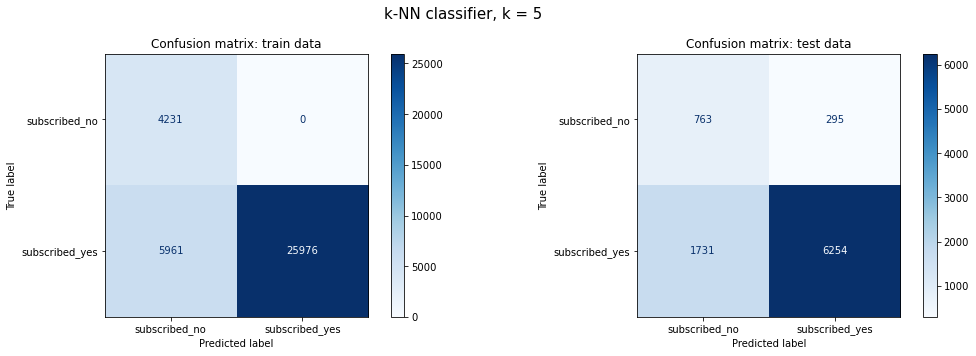

In [39]:
# 2nd model
k = 5
knn_2 = KNeighborsClassifier(n_neighbors=k, weights='distance')
knn_2.fit(X_train_resampled, y_train_resampled)

knn_evaluate(knn_2)

##################################################
Accuracy on train:  0.846300597213006
Accuracy on test:  0.7934313833904678
##################################################
Recall on train:  0.825938566552901
Recall on test:  0.8012523481527865
##################################################
Precision on train:  1.0
Precision on test:  0.9579278335080101
##################################################
Balanced accuracy on train:  0.9129692832764504
Balanced accuracy on test:  0.7678284425073951
##################################################


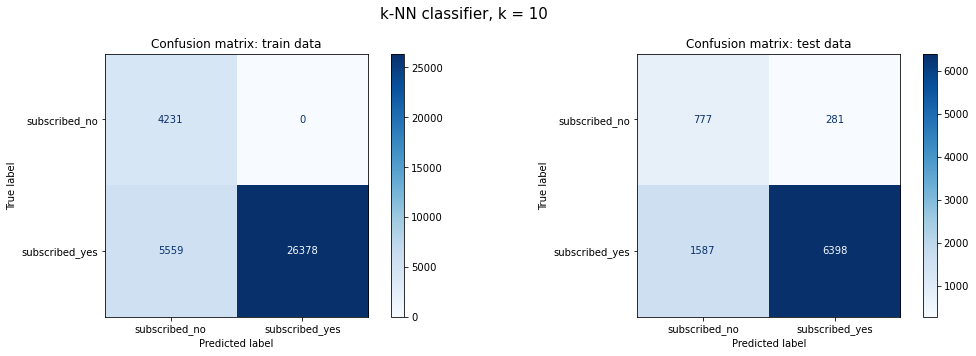

In [40]:
# 3rd model
k = 10
knn_3 = KNeighborsClassifier(n_neighbors=k, weights='distance')
knn_3.fit(X_train_resampled, y_train_resampled)

knn_evaluate(knn_3)

### 1. Holdout method
Since the performance of classifier depends greatly on training + testing split, in order to obtain a more objective measure of performance, the holdout method can be used.

In [41]:
def hold_out(k):
    N = 100
    balanced_accuracy_test = np.zeros(N)
    balanced_accuracy_train = np.zeros(N)
    for i in range(0, N):
        X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=i, stratify=Y)
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.fit_transform(X_test)
        
        # resampling
        ratio = 1.0  # ratio of majority class to minority class
        seed = i  # random seed for reproducibility

        undersampler = RandomUnderSampler(sampling_strategy=ratio, random_state=seed)
        X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)
        
        knn = KNeighborsClassifier(n_neighbors=k, weights='distance')
        knn.fit(X_train_resampled, y_train_resampled)
        y_train_pred = knn.predict(X_train)
        y_test_pred = knn.predict(X_test)
        # accuracy
        balanced_accuracy_train[i] = balanced_accuracy_score(y_true=y_train, y_pred=y_train_pred)
        balanced_accuracy_test[i] = balanced_accuracy_score(y_true=y_test, y_pred=y_test_pred)
        
    plt.figure(figsize=(10, 6))
    plt.plot(np.arange(1, N+1, 1), balanced_accuracy_train, 'o-', color='darkblue', label='training set')
    plt.plot(np.arange(1, N+1, 1), balanced_accuracy_test, 'o-', color='royalblue', label='testing set')
    plt.legend()
    plt.title('Balanced accuracy, holdout method, k-NN clasifier (distance weightening + undersampling of the majority class) k = '+str(k))
    plt.ylabel('balanced accuracy')


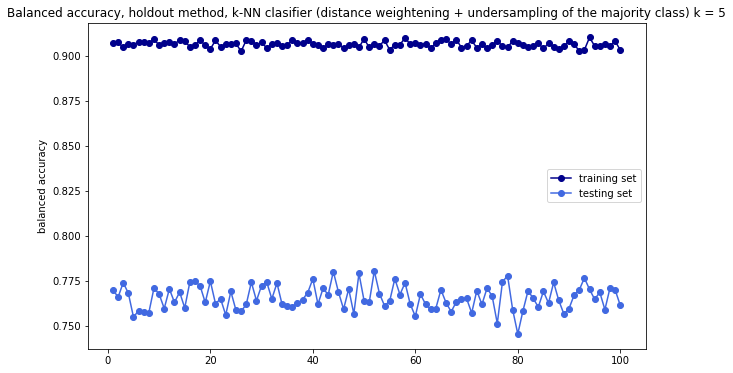

In [42]:
hold_out(k=5)

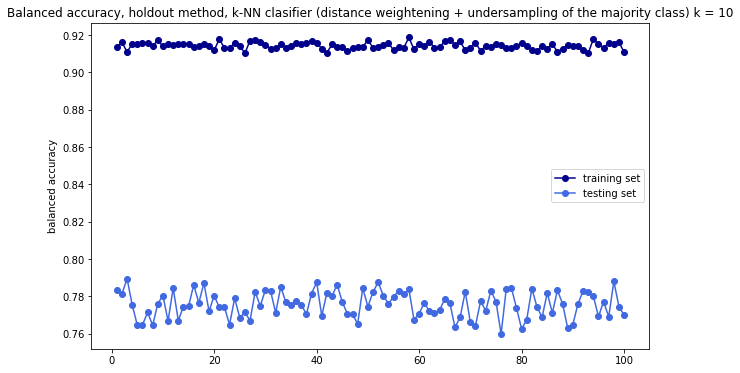

In [43]:
hold_out(k=10)

### Oversampling the minority class

In [87]:
n_minority = len(y_train[y_train == 0])
n_majority = len(y_train[y_train == 1])
print(n_minority, n_majority)

4231 31937


In [88]:
from imblearn.over_sampling import SMOTE
seed = 1
smote = SMOTE(random_state=seed)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [89]:
n_minority = len(y_train_resampled[y_train_resampled == 0])
n_majority = len(y_train_resampled[y_train_resampled == 1])
print(n_minority, n_majority)

31937 31937


##################################################
Accuracy on train:  1.0
Accuracy on test:  0.8189760035386486
##################################################
Recall on train:  1.0
Recall on test:  0.8473387601753287
##################################################
Precision on train:  1.0
Precision on test:  0.941815144766147
##################################################
Balanced accuracy on train:  1.0
Balanced accuracy on test:  0.7261268470063789
##################################################


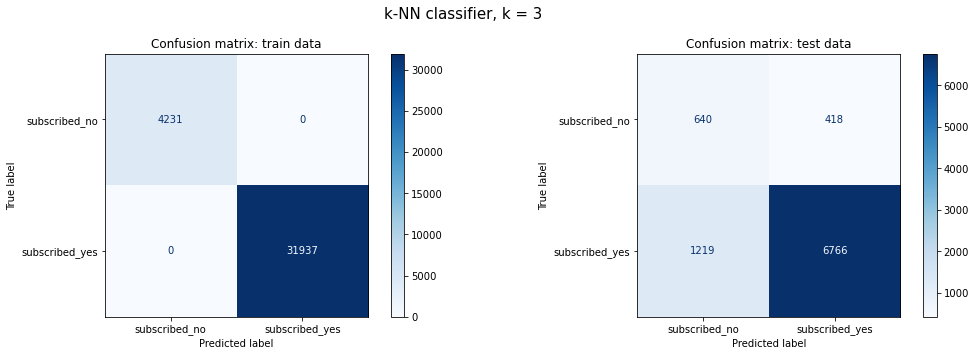

In [93]:
# 1st model
k = 3
knn_1 = KNeighborsClassifier(n_neighbors=k, weights='distance')
knn_1.fit(X_train_resampled, y_train_resampled)

knn_evaluate(knn_1)

Oversampling the minority class leads to overfitting, which is obvious here...

##################################################
Accuracy on train:  1.0
Accuracy on test:  0.8047108260533009
##################################################
Recall on train:  1.0
Recall on test:  0.8190356919223544
##################################################
Precision on train:  1.0
Precision on test:  0.9532138172278094
##################################################
Balanced accuracy on train:  1.0
Balanced accuracy on test:  0.7578165227097594
##################################################


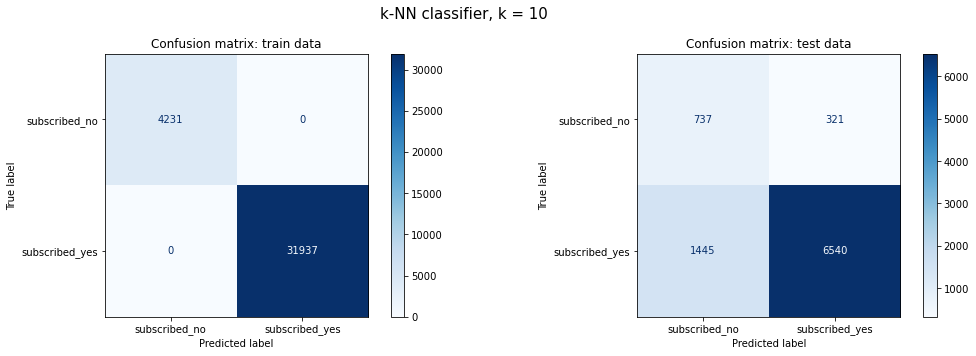

In [98]:
# 2st model
k = 10
knn_1 = KNeighborsClassifier(n_neighbors=k, weights='distance')
knn_1.fit(X_train_resampled, y_train_resampled)

knn_evaluate(knn_1)

Results for the undersampling seem to be better in this case. So, let's stick with undersampling...

### 2. k-fold cross-validation

In [48]:
# Trying something

from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer


def hold_out_and_cross_val(k):
    N = 100
    balanced_accuracy_test_hold_out = np.zeros(N)
    balanced_accuracy_train_hold_out = np.zeros(N)
    balanced_accuracy_test_cross_val = np.zeros(N)
    # resampling
    ratio = 1.0  # ratio of majority class to minority class
    seed = 24  # random seed for reproducibility

    undersampler = RandomUnderSampler(sampling_strategy=ratio, random_state=seed)
    X_resampled, Y_resampled = undersampler.fit_resample(X, Y)


    for i in range(0, N):
        X_train, X_test, y_train, y_test = train_test_split(X_resampled, Y_resampled, test_size=0.20, random_state=i, stratify=Y_resampled)
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.fit_transform(X_test)
        
        knn = KNeighborsClassifier(n_neighbors=k, weights='distance')
        knn.fit(X_train, y_train)
    
        y_test_pred = knn.predict(X_test)
        # balanced accuracy
        balanced_accuracy_test_hold_out[i] = balanced_accuracy_score(y_true=y_test, y_pred=y_test_pred)
        
        # perform k-fold cross-validation

        estimators = [('standardize', StandardScaler()), ('knn', KNeighborsClassifier())]
        pipeline = Pipeline(estimators)

        scores = cross_val_score(pipeline, X_resampled, Y_resampled, cv=10, scoring='balanced_accuracy')
        balanced_accuracy_test_cross_val[i] = np.mean(scores)
        
    plt.figure(figsize=(10, 6))
    plt.plot(np.arange(1, N+1, 1), balanced_accuracy_test_cross_val, 'o-', color='darkblue', label='k-fold cross-validation')
    plt.plot(np.arange(1, N+1, 1), balanced_accuracy_test_hold_out, 'o-', color='royalblue', label='hold out')
    plt.legend()
    plt.title('Balanced accuracy on testing set\nholdout and k-fold cross-validation method, \nk-NN clasifier (distance weightening + undersampling of the majority class) k = '+str(k))
    plt.ylabel('balanced accuracy')
    plt.show()

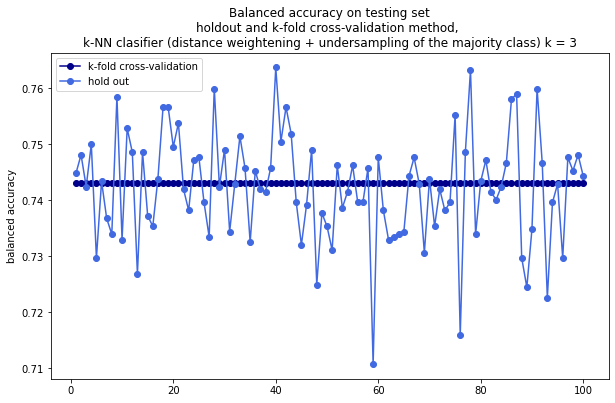

In [49]:
hold_out_and_cross_val(k=3)
# k-fold cross-validation should give stable estimation of accuracy


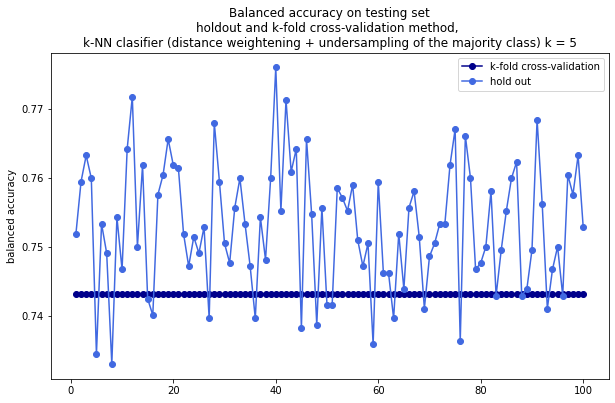

In [50]:
hold_out_and_cross_val(k=5)

Now: taking into account impact of random undersampling. Previously: fixed undersampling

In [51]:
def hold_out_and_cross_val(k):
    N = 100
    balanced_accuracy_test_hold_out = np.zeros(N)
    balanced_accuracy_train_hold_out = np.zeros(N)
    balanced_accuracy_test_cross_val = np.zeros(N)

    for i in range(0, N):
        ratio = 1.0  # ratio of majority class to minority class
        seed = 24  # random seed for reproducibility

        undersampler = RandomUnderSampler(sampling_strategy=ratio, random_state=seed)
        X_resampled, Y_resampled = undersampler.fit_resample(X, Y)
        
        X_train, X_test, y_train, y_test = train_test_split(X_resampled, Y_resampled, test_size=0.20, random_state=i, stratify=Y_resampled)
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.fit_transform(X_test)
        
        
        knn = KNeighborsClassifier(n_neighbors=k, weights='distance')
        knn.fit(X_train, y_train)
        y_test_pred = knn.predict(X_test)
        # balanced accuracy
        balanced_accuracy_test_hold_out[i] = balanced_accuracy_score(y_true=y_test, y_pred=y_test_pred)
        
        # perform k-fold cross-validation
        
        # Have tried multiple ways to integrate undersampler into pipeline, but it didn't work
        # estimators = [('standardize', StandardScaler()), ('undersample', FunctionTransformer(RandomUnderSampler(), validate=False)), ('knn', KNeighborsClassifier(weights='distance'))]

        estimators = [('standardize', StandardScaler()), ('knn', KNeighborsClassifier())]
        pipeline = Pipeline(estimators)

        scores = cross_val_score(pipeline, X_resampled, Y_resampled, cv=10, scoring='balanced_accuracy')
        balanced_accuracy_test_cross_val[i] = np.mean(scores)
        
    plt.plot(np.arange(1, N+1, 1), balanced_accuracy_test_cross_val, 'o-', color='darkblue', label='k-fold cross-validation')
    plt.plot(np.arange(1, N+1, 1), balanced_accuracy_test_hold_out, 'o-', color='royalblue', label='hold out')
    plt.legend()
    plt.title('Balanced accuracy on testing set, \nholdout and k-fold cross-validation method, \nk-NN clasifier (distance weightening + undersampling of the majority class) k = '+str(k))
    plt.ylabel('balanced accuracy')


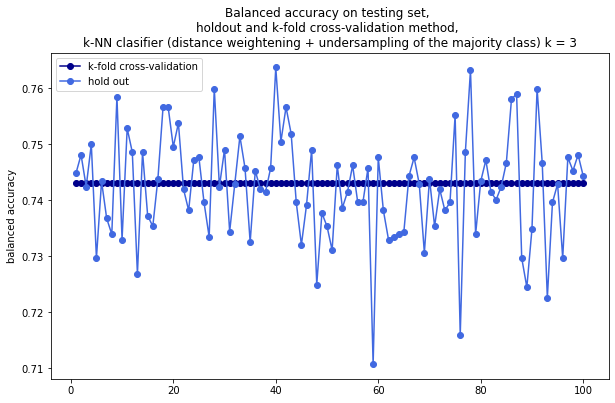

In [52]:
hold_out_and_cross_val(k=3)


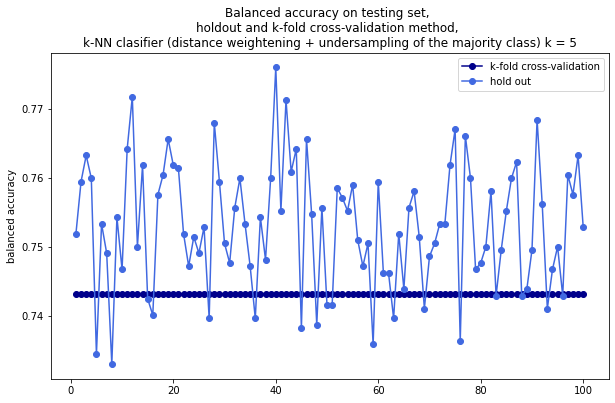

In [53]:
hold_out_and_cross_val(k=5)


### Trade-off: complexity vs. generalization
Plotting the (validation) testing curve in order to find optimal k

Let's include variaty in random resampling to better evaluate the performance of the kNN classifier.

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


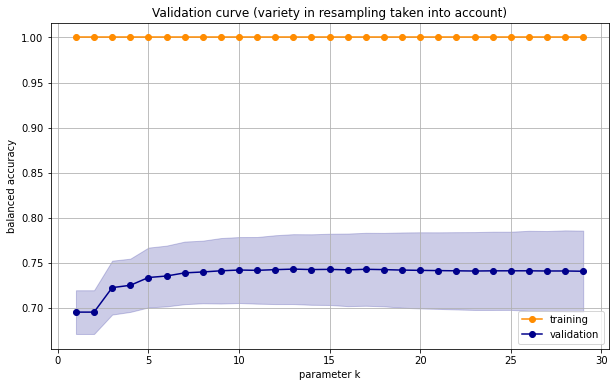

In [55]:
from sklearn.model_selection import validation_curve
# evaluate model performance using validation_curve

num_iterations = 20 # number of different resamplings
k_max = 30
param_range = np.arange(1, k_max) # range for parameter k
train_mean = np.zeros([num_iterations, k_max-1])
train_std = np.zeros([num_iterations, k_max-1])
test_mean = np.zeros([num_iterations, k_max-1])
test_std = np.zeros([num_iterations, k_max-1])

for i in range(0, num_iterations):
    print(i)
    # resampling
    ratio = 1.0  # ratio of majority class to minority class
    seed = i  # random seed for reproducibility

    undersampler = RandomUnderSampler(sampling_strategy=ratio, random_state=seed)
    X_resampled, Y_resampled = undersampler.fit_resample(X, Y)

    estimators = [('standardize', StandardScaler()), ('knn', KNeighborsClassifier(weights='distance'))]
    pipeline = Pipeline(estimators)
    train_scores, test_scores = validation_curve(
        pipeline,
        X_resampled, Y_resampled,
        param_name='knn__n_neighbors',
        param_range=param_range,
        cv=5,
        scoring='balanced_accuracy'
    )

    # column: score for specific fold for different k
    # row: results for specific k for different folds

    train_mean[i, :] = np.mean(train_scores, axis=1)
    train_std[i, :] = np.std(train_scores, axis=1)
    test_mean[i, :] = np.mean(test_scores, axis=1)
    test_std[i, :] = np.std(test_scores, axis=1)
 
train_mean_final = np.mean(train_mean, axis=0)
train_std_final = np.mean(train_std, axis=0)
test_mean_final = np.mean(test_mean, axis=0)
test_std_final = np.mean(test_std, axis=0)

fig = plt.figure(figsize=(10, 6))
plt.plot(param_range, train_mean_final, 'o-', label='training', color='darkorange')
plt.fill_between(param_range, train_mean_final - train_std_final, train_mean_final + train_std_final, alpha=0.2, color='darkorange')
plt.plot(param_range, test_mean_final, 'o-', label='validation', color='darkblue')
plt.fill_between(param_range, test_mean_final - test_std_final, test_mean_final + test_std_final, alpha=0.2, color='darkblue')

plt.title('Validation curve (variety in resampling taken into account)')
plt.xlabel('parameter k')
plt.ylabel('balanced accuracy')
plt.legend()
plt.grid()
plt.savefig('knn_4.jpg', dpi=fig.dpi)
plt.show()


In [56]:
# Let's choose k=10 as optimal
# Training such classifier and evaluating 
ratio = 1.0  # ratio of majority class to minority class
seed = 1  # random seed for reproducibility

undersampler = RandomUnderSampler(sampling_strategy=ratio, random_state=seed)
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)

n_minority = len(y_train_resampled[y_train_resampled == 0])
n_majority = len(y_train_resampled[y_train_resampled == 1])
print(n_minority, n_majority)

4231 4231


##################################################
Accuracy on train:  0.846300597213006
Accuracy on test:  0.7934313833904678
##################################################
Recall on train:  0.825938566552901
Recall on test:  0.8012523481527865
##################################################
Precision on train:  1.0
Precision on test:  0.9579278335080101
##################################################
Balanced accuracy on train:  0.9129692832764504
Balanced accuracy on test:  0.7678284425073951
##################################################


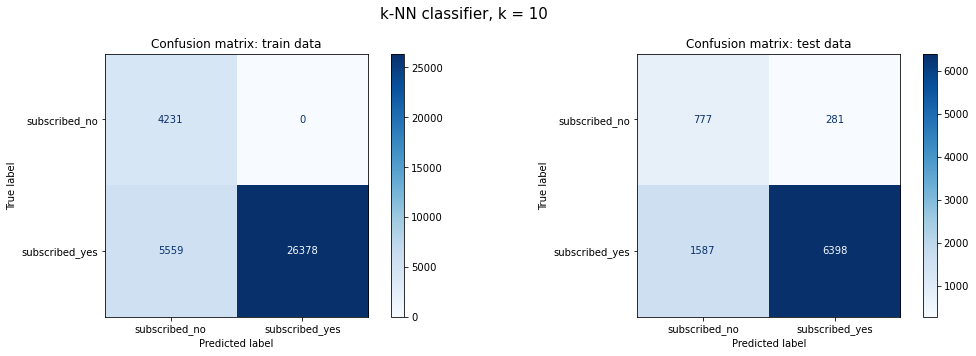

In [57]:
k = 10
knn_optimal = KNeighborsClassifier(n_neighbors=k, weights='distance')
knn_optimal.fit(X_train_resampled, y_train_resampled)

knn_evaluate(knn_optimal)

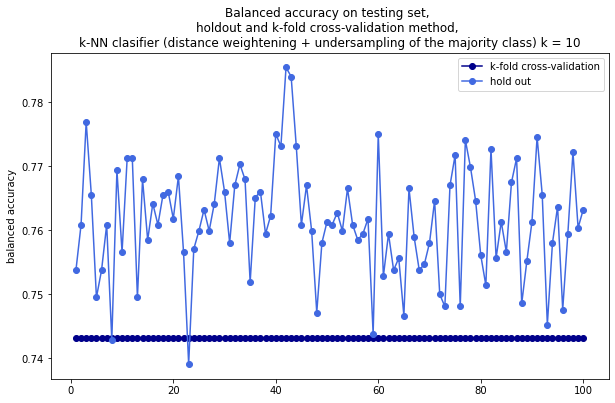

In [58]:
hold_out_and_cross_val(k=10)  # number of folds: 10

### Efficiency: Runtime
Total runtime for training & testing k-NN classifier (k-fold cross validation), 
- k  : 10
- cv : 10

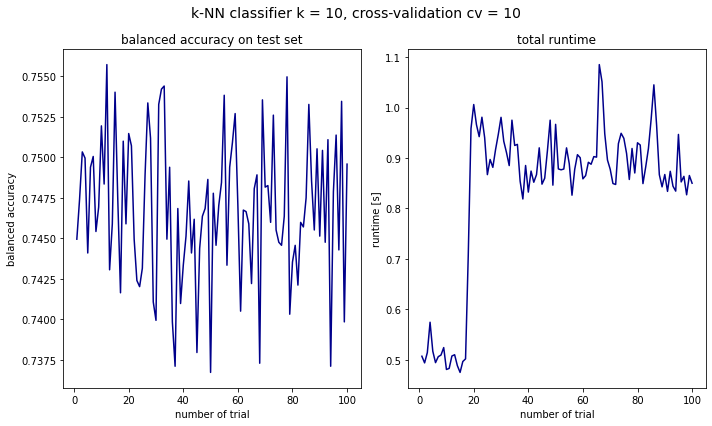

In [61]:
import time

runtime = np.zeros(100)
balanced_acc_test = np.zeros(100)

for i in range(0, 100):
    start_time = time.time()
    
    ratio = 1.0  # ratio of majority class to minority class
    seed = i  # random seed for reproducibility
    undersampler = RandomUnderSampler(sampling_strategy=ratio, random_state=seed)
    X_resampled, y_resampled = undersampler.fit_resample(X, Y)
    
    estimators = [('standardize', StandardScaler()), ('knn', KNeighborsClassifier())]
    pipeline = Pipeline(estimators)
    scores = cross_val_score(pipeline, X_resampled, y_resampled, cv=10)
    balanced_acc_test[i] = np.mean(scores)

    end_time = time.time()

    runtime[i] = end_time - start_time
    
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.plot(np.arange(1, 101), balanced_acc_test, '-', color='darkblue')
plt.ylabel('balanced accuracy')
plt.xlabel('number of trial')
plt.title('balanced accuracy on test set')

plt.subplot(1, 2, 2)
plt.plot(np.arange(1, 101), runtime, '-', color='darkblue')
plt.ylabel('runtime [s]')
plt.xlabel('number of trial')
plt.title('total runtime')

plt.suptitle('k-NN classifier k = 10, cross-validation cv = 10', fontsize=14)
plt.tight_layout()

plt.show()

In [62]:
print('Mean accuracy : ', str(np.mean(balanced_acc_test)))
print('Mean runtime  : ', str(np.mean(runtime)), ' s')

Mean accuracy :  0.7468076483538495
Mean runtime  :  0.8327833676338195  s


## Naive Bayes classification

### Data without scaling

In [92]:
X = df_bank_dummies.drop(['class'], axis=1)
Y = df_bank_dummies['class']

#Splitting data in train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.20, random_state = 1234,stratify=Y)

#### Gaussian Naive Bayes

####################
Accuracy on train: 86.10 %
Accuracy on test: 85.31 %
####################
Balanced accuracy on train: 69.80 %
Balanced accuracy on test 68.23 %
####################
Recall on train: 69.80 %
Recall on test: 68.23 %
####################
Precision on train: 67.46 %
Precision on test: 65.90 %


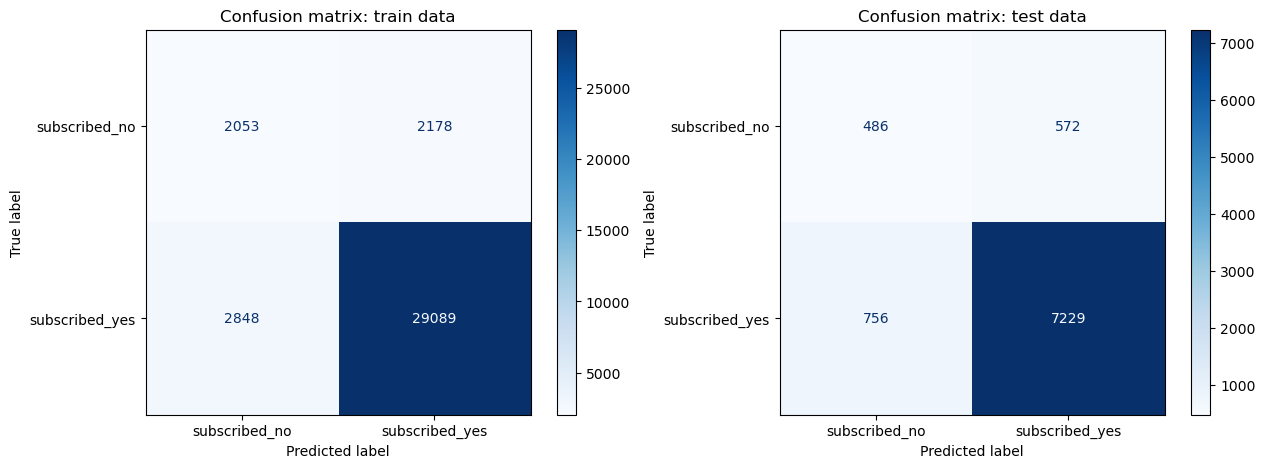

In [93]:
from sklearn.naive_bayes import GaussianNB

# Create a Gaussian Naive Bayes classifier and fit it to the training data
gnb_model = GaussianNB()
gnb_model.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = gnb_model.predict(X_test)

evaluate(gnb_model)


In [94]:
from sklearn.model_selection import cross_val_score

# Use cross-validation to estimate the classifier's accuracy
scores = cross_val_score(gnb_model, X_train, y_train, cv=5)

# Print the cross-validation scores
print("Cross-validation scores:", scores)

# Calculate the mean and standard deviation of the scores
print("Mean score:", scores.mean())
print("Standard deviation:", scores.std())

Cross-validation scores: [0.85899917 0.85761681 0.8587227  0.86077699 0.8675515 ]
Mean score: 0.8607334345726958
Standard deviation: 0.0035567400245155047


#### Bernoulli Naive Bayes:

####################
Accuracy on train: 85.24 %
Accuracy on test: 85.04 %
####################
Balanced accuracy on train: 61.00 %
Balanced accuracy on test 60.08 %
####################
Recall on train: 61.00 %
Recall on test: 60.08 %
####################
Precision on train: 62.70 %
Precision on test: 61.89 %


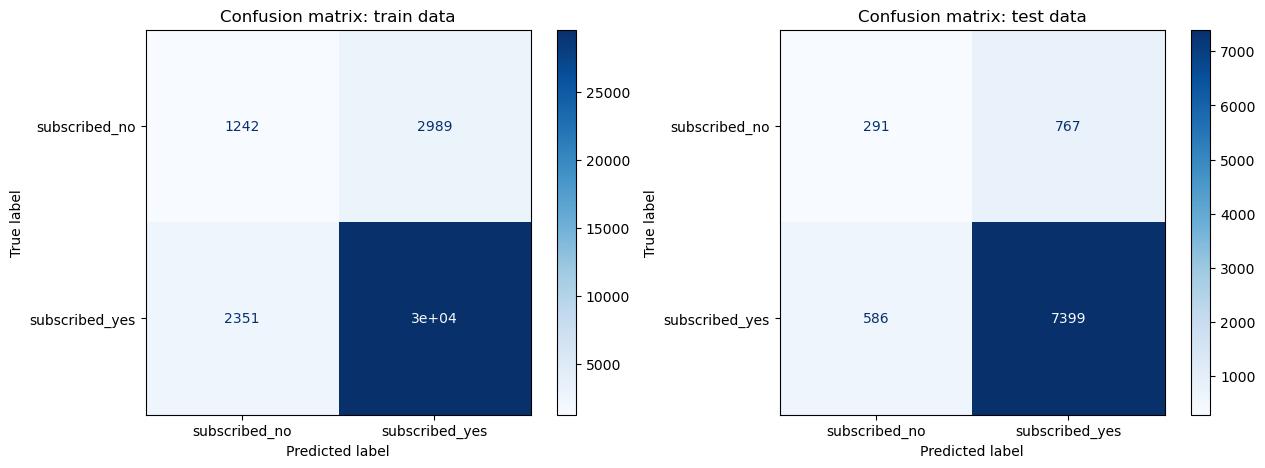

In [95]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score

bnb_model = BernoulliNB()
bnb_model.fit(X_train, y_train)

# Prediction
# y_pred = bnb_model.predict(X_test)

evaluate(bnb_model)

### Data preparation (Scaling)
Multinominal, complement and categorical classification do not allow negative values. Therefore scaling and normalization ist tested for the dataset us

In [96]:
def find_negative_columns(X):
    neg_df = X[(X < 0).any(axis=1)]
    try:
        cols_with_negatives = neg_df.columns[(neg_df < 0).any()]
        print('column with negative values:', cols_with_negatives.values)
    except:
        print('there are no negative values')

find_negative_columns(X=X)

column with negative values: ['balance' 'pdays']


In [97]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB

X = df_bank_dummies.drop(['class'], axis=1)
Y = df_bank_dummies['class']


#Splitting data in train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.20, random_state = 1234, stratify=Y)

# Normalize the data (mean=0 and std=1)
# norm = StandardScaler().fit(X_train)
# norm = StandardScaler()
# X_train_norm = norm.fit_transform(X_train)
# X_test_norm = norm.transform(X_test)

print('normalization does not remove negative values. Therefore min-max-scaling is done')

# Scale the data (min=0 max=1)
scale = MinMaxScaler()
X_train_scale = scale.fit_transform(X_train)
X_test_scale = scale.transform(X_test)

normalization does not remove negative values. Therefore min-max-scaling is done


#### Gaussian Naive Bayes

Gaussian Naive Bayes with min-max-scaled data:
####################
Accuracy on train: 85.07 %
Accuracy on test: 84.31 %
####################
Balanced accuracy on train: 69.51 %
Balanced accuracy on test 68.16 %
####################
Recall on train: 69.51 %
Recall on test: 68.16 %
####################
Precision on train: 66.04 %
Precision on test: 64.71 %


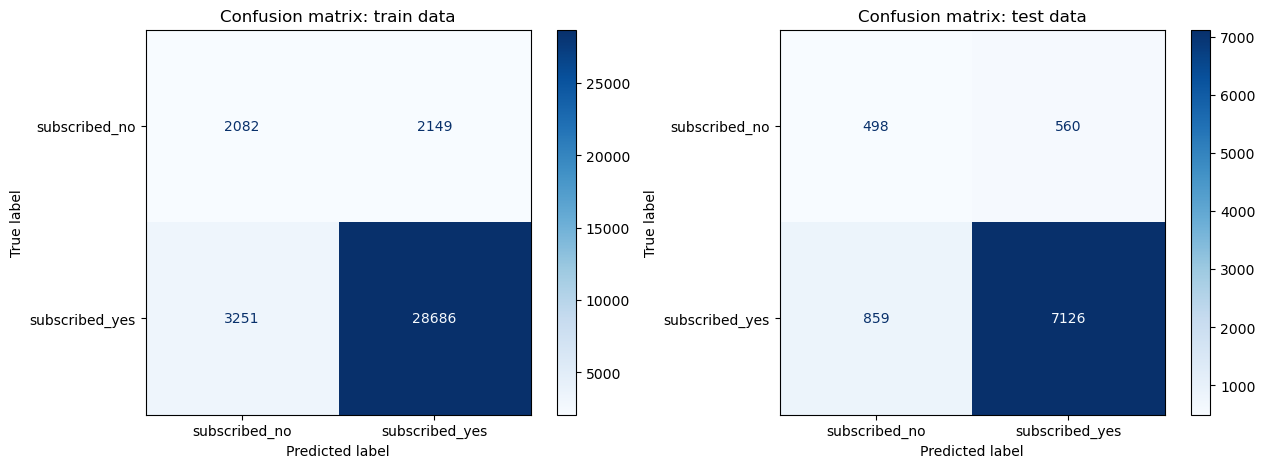

In [98]:
# Train and evaluate Gaussian Naive Bayes with scaled data
print('Gaussian Naive Bayes with min-max-scaled data:')
gnb_model_scale = GaussianNB()
gnb_model_scale.fit(X_train_scale, y_train)
evaluate(gnb_model_scale, X_train_scale, X_test_scale)

#### Bernoulli Naive Bayes

Bernoulli Naive Bayes with min-max-scaled data:
####################
Accuracy on train: 85.53 %
Accuracy on test: 85.23 %
####################
Balanced accuracy on train: 61.11 %
Balanced accuracy on test 60.27 %
####################
Recall on train: 61.11 %
Recall on test: 60.27 %
####################
Precision on train: 63.21 %
Precision on test: 62.28 %


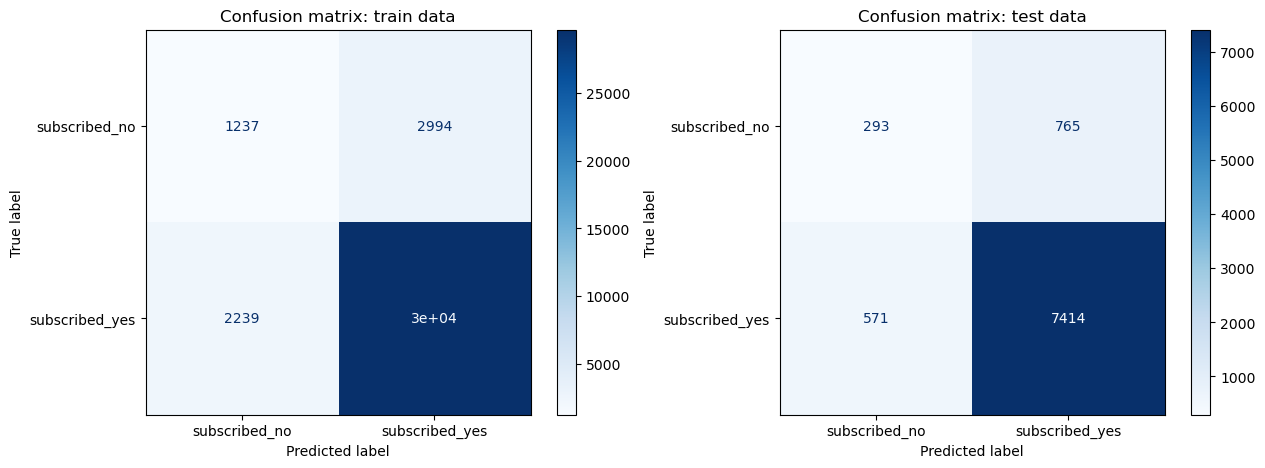

In [99]:
# Train and evaluate Bernoulli Naive Bayes with scaled data
print('Bernoulli Naive Bayes with min-max-scaled data:')
bnb_model_scale = BernoulliNB()
bnb_model_scale.fit(X_train_scale, y_train)
evaluate(bnb_model_scale, X_train_scale, X_test_scale)

#### Multinomial Naive Bayes:

Multinominal Naive Bayes with min-max-scaled data:
####################
Accuracy on train: 89.32 %
Accuracy on test: 89.21 %
####################
Balanced accuracy on train: 58.54 %
Balanced accuracy on test 57.73 %
####################
Recall on train: 58.54 %
Recall on test: 57.73 %
####################
Precision on train: 77.79 %
Precision on test: 77.57 %


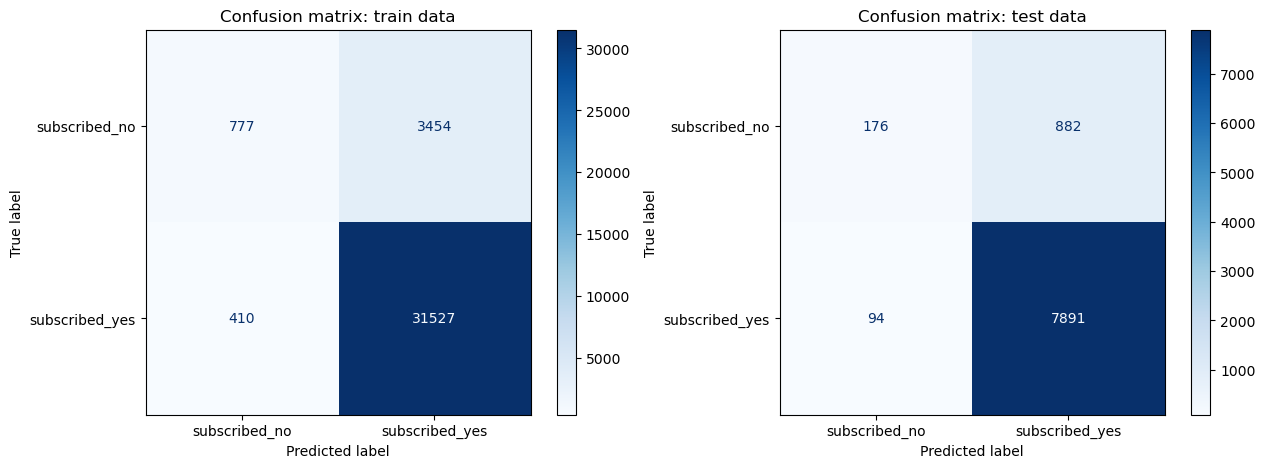

In [100]:
# Train a Multinomial Naive Bayes classifier on the training data
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix

#mnb_model = MultinomialNB()
#mnb_model.fit(X_train, y_train)

# Train and evaluate Gaussian Naive Bayes with scaled data
print('Multinominal Naive Bayes with min-max-scaled data:')
mnb_model_scale = MultinomialNB()
mnb_model_scale.fit(X_train_scale, y_train)
evaluate(mnb_model_scale, X_train_scale, X_test_scale)

#### Complement Naive Bayes:

Complement Naive Bayes with min-max-scaled data:
####################
Accuracy on train: 74.39 %
Accuracy on test: 74.70 %
####################
Balanced accuracy on train: 67.31 %
Balanced accuracy on test 66.61 %
####################
Recall on train: 67.31 %
Recall on test: 66.61 %
####################
Precision on train: 58.97 %
Precision on test: 58.76 %


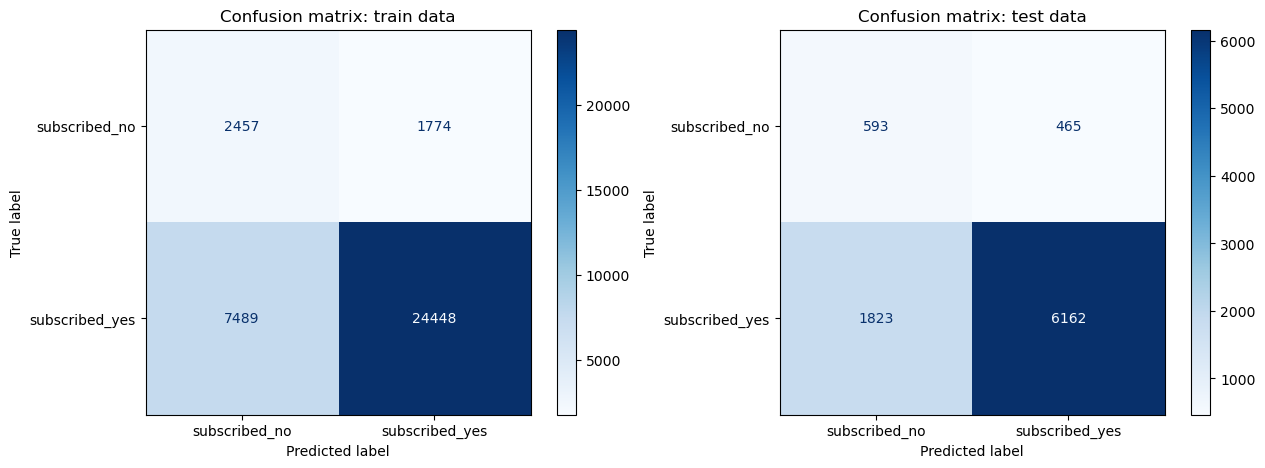

In [101]:
from sklearn.naive_bayes import ComplementNB

# Train and evaluate Gaussian Naive Bayes with scaled data
print('Complement Naive Bayes with min-max-scaled data:')
cnb_model_scale = ComplementNB()
cnb_model_scale.fit(X_train_scale, y_train)
evaluate(cnb_model_scale, X_train_scale, X_test_scale)

#### Grid search to improve Gaussian naive bayes

Best hyperparameters: {'gnb__var_smoothing': 1e-05}
####################
Accuracy on train: 85.10 %
Accuracy on test: 84.34 %
####################
Balanced accuracy on train: 69.53 %
Balanced accuracy on test 68.17 %
####################
Recall on train: 69.53 %
Recall on test: 68.17 %
####################
Precision on train: 66.08 %
Precision on test: 64.75 %


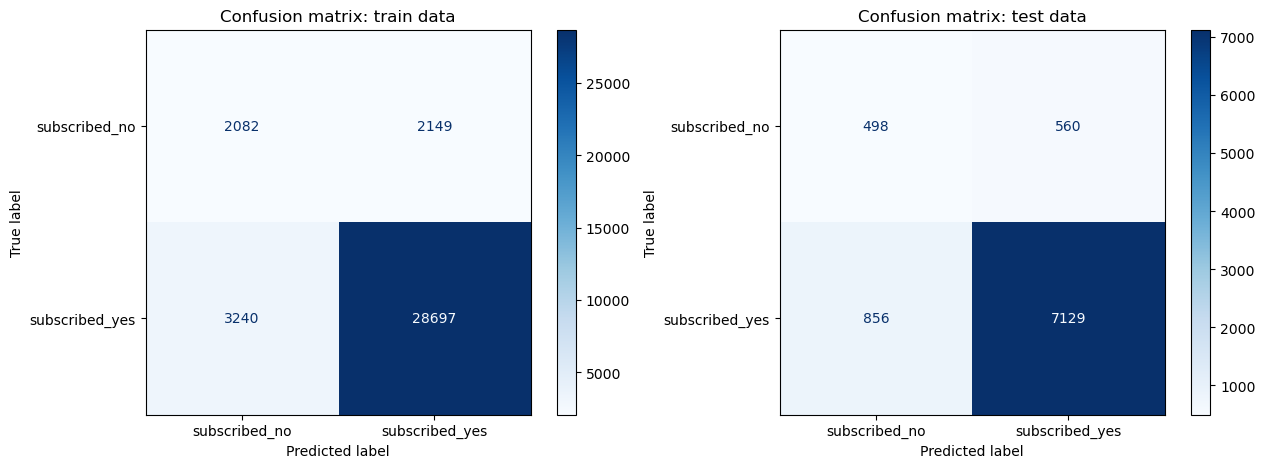

In [102]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('gnb', GaussianNB())
])

param_grid={'gnb__var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]}

grid_search_gnb_model = GridSearchCV(pipeline, param_grid=param_grid, cv=5)

grid_search_gnb_model.fit(X_train, y_train)

print('Best hyperparameters: {}'.format(grid_search_gnb_model.best_params_))
# print('Best mean cross-validation score: {}'.format(grid_search_gnb_model.best_score_))

evaluate(grid_search_gnb_model)

In [103]:
def generate_latex_table_str(model, name, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test):
    model.fit(X_train, y_train)
    y_train_hat = model.predict(X_train)
    y_test_hat = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_test_hat)
    b_accuracy = balanced_accuracy_score(y_test, y_test_hat)
    recall = recall_score(y_test, y_test_hat, average='macro')
    precision = precision_score(y_test, y_test_hat, average='macro')
    
    
    print(' {} & {:.2f} \% & {:.2f} \%  & {:.2f} \% & {:.2f} \% \{}'.format(name, accuracy*100, b_accuracy*100, recall*100, precision*100, '\\'))
    print(' \hline')


In [104]:
generate_latex_table_str(gnb_model, 'Gaussian Naive Bayes')
generate_latex_table_str(bnb_model, 'Bernoulli NB')
generate_latex_table_str(gnb_model_scale, 'Gaussian NB (scaled)', X_train=X_train_scale, X_test=X_test_scale)
generate_latex_table_str(bnb_model_scale, 'Bernoulli NB (scaled)', X_train=X_train_scale, X_test=X_test_scale)
generate_latex_table_str(mnb_model_scale, 'Multinomial NB (scaled)', X_train=X_train_scale, X_test=X_test_scale)
generate_latex_table_str(cnb_model_scale, 'Complement NB (scaled)', X_train=X_train_scale, X_test=X_test_scale)
generate_latex_table_str(grid_search_gnb_model, 'Gaussian NB HP tuned', X_train=X_train_scale, X_test=X_test_scale)

 Gaussian Naive Bayes & 85.31 \% & 68.23 \%  & 68.23 \% & 65.90 \% \\
 \hline
 Bernoulli NB & 85.04 \% & 60.08 \%  & 60.08 \% & 61.89 \% \\
 \hline
 Gaussian NB (scaled) & 84.31 \% & 68.16 \%  & 68.16 \% & 64.71 \% \\
 \hline
 Bernoulli NB (scaled) & 85.23 \% & 60.27 \%  & 60.27 \% & 62.28 \% \\
 \hline
 Multinomial NB (scaled) & 89.21 \% & 57.73 \%  & 57.73 \% & 77.57 \% \\
 \hline
 Complement NB (scaled) & 74.70 \% & 66.61 \%  & 66.61 \% & 58.76 \% \\
 \hline
 Gaussian NB HP tuned & 84.34 \% & 68.17 \%  & 68.17 \% & 64.75 \% \\
 \hline
